# Машинное обучение по оттоку клиентов на примере сети фитнес-центров «Культурист-датасаентист»

Задачи проекта:

 - Провести исследовательный анализ данных, построить столбчатые диаграммы для каждого признака по делению Churn;
 - Выбрать модель прогнозирования оттока клиентов и обучить её по нашим данным;
 - Нарисовать дендограмму и провести кластеризацию клиентов;
 - Выявить лояльные и нелояльные кластеры клиентов и описать средние параметры по ним;
 - Сделать общие вывозы и базовы рекоментазии по работе с клиентами.

## Шаг №1. Загрузка данных и подготовка их к анализу

In [1]:
#импортируем необходимые библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
#откроем таблицу и выведем её на экран
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
# Проверим нашу таблицу на дубликаты
print('В таблице', gym_churn.duplicated().sum(), 'дубликатов')

В таблице 0 дубликатов


In [4]:
# посмотрим основную информацию по таблице gym_churn
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


### Вывод

У нас таблица состоит из 4000 строк, где нет ни одного пропуска и 14 столбцов:

 - gender — пол;
 - Near_Location — проживание или работа в районе, где находится фитнес-центр;
 - Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
 - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
 - Phone — наличие контактного телефона;
 - Contract_period — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
 - Group_visits — факт посещения групповых занятий;
 - Age — возраст;
 - Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон;
 - Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
 - Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).
 - Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
 - Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
 - Churn — факт оттока в текущем месяце.

## Шаг №2. Исследовательский анализ данных (EDA)

In [5]:
# Посмотрим сколько людей остались клиентами фитнес центра и сколько клиентов покинуло его
print(len(gym_churn[gym_churn['Churn'] ==0]), 'человек остались клиентами фитнес центра')
print('И', len(gym_churn[gym_churn['Churn'] ==1]), 'человек перестали пользоваться его услугами')

2939 человек остались клиентами фитнес центра
И 1061 человек перестали пользоваться его услугами


In [6]:
# Посмотрим основные числовые характеристики для нашей таблицы
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Столбец gender - пол клиента, где есть 0 и 1, где неизвестно где какой пол. Но среднее составляет 0,51, что означает, что примерно поровну мужчин и женщин посещает данный фитнес-центр.

Столбец Near_Location - проживание или работа, где находится фитнес центр со значеями 1 и 0, где 1 - это да, 0 - это нет. Среднее 0,84, то есть у большинство клиентов данного фитнес-центра проживают или работают по близости.

Столбец Partner - сотрудник компании-партнёра клуба, где 0 - это работодатель клиента не является партнёром фитнес-центра, и 1 - это работодатель клиента является партнёром фитнес-центра. Среднее составляет 0,48 и стандартное отклонение состаляет 0,48 - это говорит о том, что чуть меньше половины работадателей клиентов являются партнёрами данного фитнес клуба.

Столбец Promo_friends - факт первоначальной записи в рамках акции «приведи друга», где 0 - это что клиент сам пришёл в фитнес клуб, и 1 - это где клиент пришёл по рекомендации друга. Среднее состаляет 0,3, а стандартное отклонение 0,46. Это говорит о том, что только около 30% клиентов занимаются в фитнес центре по рекомендации знакомых или же со знакомыми.

Столбец Phone - наличие контактного телефона, 1 - клиент отставлял контактный телефон, 0 - не оставлял. Среднее состаляет 0,9, это говорит, что 90% клиентов оставило свой контактный телефон.

Стобец Contract_period - длительность текущего действующего абонемента, где 1 - месяц, 3 - три месяца, 6 - пол года, 12 - год. Медиана равна 1, 75% квантиль равен 6 - это означает, что больнинство клиентов имеет месячный абонемент и лишь около 25% 6 месяцев и выше.

Столбец Group_visits - факт посещения групповых занятий, где 1 - что клиент посещал/посещает групповые занятия, 0 - не посещает. Среднее составляла 0,41 - что означает, что только около 60% клиентов данного фитнес клуба не посещает групповые занятия.

Столбец Age, в котором указан возраст клиента, имеет среднее 29,18 и стандартное отклонение 3,25 - это означает, что большинство клиентов фитнес-центра имеет возврат от 26 до 32 лет.

Столбец Avg_additional_charges_total, в котором указана суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон, имеет среднее 146,9 и среднее отклонение 96,35. Что означает, что больнишство клиентов тратит на от 50 до 240 у.е. на услуги данного фитнес-центра.

Столбец Month_to_end_contract, в котором указан срок до окончания текущего действующего абонемента, имеет среднее значение 4,32, медиану - 1 и 75% квантиль - 1. Это означает, что в таблице есть выбросы по данному столбцу, так как большинство (около 75%) клиентов имеют до конца действия абонемента всего 1 месяц, но при это среднее ососталяет 4,32 месяца.

Столбец Lifetime, в котором указано время с момента первого обращения в фитнес-центр (в месяцах) , имеет среднее 3,72 и медиану 3. Что означает, что в среднем клиенты состоят в клубе около 3 месяцев.

Столбец Avg_class_frequency_total, в котором указана средняя частота посещений в неделю за все время с начала действия абонемента, имеет среднее 1,87 и медиану 1,83 - это означает что в среднем клиенты посещают фитнес клуб 2 раза в неделю. Но среднее отклонение  в 0,97 говорит, что имеется достаточно большой разброс, до 2х посещений в неделю, между разными клиентами.

Столбец Avg_class_frequency_current_month, в котором указана средняя частота посещений в неделю за предыдущий месяц, имеет среднее 1,76 и медиану в 1,71, что означает, что за последнюю неделю клиенты посещают чуть менее активно фитнес-центр, чем за всё время пользования абонементом. Но в целом это ни о чём не говорит, так как это может быть сезонное влияние (допустим летом люди менее активно посещают фитнес) или же на значения могли повлиять 0 значение от клиентов, которые покинули фитнес клуб. Среднее отклонение равно 1,05 = это значит, что имеется достаточно большой разброс, до 2х посещений в неделю, между разными клиентами.

Столбец Churn - факт оттока в текущем месяце, где 0 - означает, что клиент не покинул фитнес клуб, и где 1 - означает, что клиент больше не посещает фитнес-центр. Среднее равно 0,26 - что показывает, что около 26% клиентов из данной выборки отказались от посещения фитнес-центра по тем или иным причинам.

У всех переменных разные по величине стандартные отклонения. Это говорит о том, что нужно стандартизировать данные перед обучением.

In [7]:
# Посмотрим основные числовые характеристики для нашей таблицы для клиентов, какие покинули фитнес клуб
gym_churn[gym_churn.Churn == 1].describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.0
mean,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546,1.0
std,0.500118,0.422217,0.478837,0.387495,0.296204,2.132371,0.443448,2.895163,77.696419,1.964593,1.110799,0.694705,0.770237,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,50.629127,1.000000,0.000000,1.010771,0.421337,1.0
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,103.814686,1.000000,1.000000,1.491187,0.979445,1.0
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,29.000000,165.616858,1.000000,1.000000,1.956438,1.588576,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,38.000000,425.535220,12.000000,9.000000,3.478646,3.540271,1.0


Клиенты какие покинули фитнес-центр имеют следующие характеристики по таблице.

По столбцу gender видим среднее состаляет 0,51 это означает, что примерно одинаковое количество женщин и мужчин перестали посещать фитнес.

По столбцу Near_Location видим среднее состаляет 0,76. Значит 76% данных клиентов имеют жильё или работу рядом с данным фитнес центром. По всей таблице 84% клиентов живут или работают рядом.

По столбцу Partner видим среднее состаляет 0,35 это значит, что 35% работадателей клиентов, покинувших фитнес центр, являются партнёрами данного фитнес клуба. По всем клиентам эта величина составляет 48%. Что уже указывает на то, что если работодатель оплачивает целиком или частично фитнес, то клиент с таким работодателем с большей вероятностью будет продолжать посещать фитнес центр.

По столбцу Promo_friends видим среднее состаляет 0,18 это означает, что 18% клиентов покинувших фитнес центр занимались по рекомендации друга. По всем клиентам эта величина состаляет 30%. Что показывает на то, что клиент с большей вероятностью будет продолжать посещать фитнес центр, если помимо него его посещает также его знакомый.

По столбцу Phone видим среднее состаляет 0,9 это означает,что 90% клиентов оставили свой контактный телефон. У всех клиентов среднем тот же показатель. То есть данный показатель слабо коррелирует с вероятностью оттока клиента.

По столбцу Contract_period видим среднее состаляет 1,72 и медиану 1 это означает, что в основном клиенты имели месячный абонемент. Так как среднее по всем клиентам состаляло 4,68, что означает, что чем дольше клиент ходит в данный фитнес центр тем более лояльным он становится и с меньшей вероятностью перестанет посещать фитнес.

По столбцу Group_visits видим среднее состаляет 0,26 это означает, что только 26% клиентов посещало групповые занятия. По всей же таблице данный показатель составлял 41%, что уже говорит о том, клиенты посещающие групповые занятия с меньшей вероятностью перестанут посещать фитнес.

По столбцу Age видим среднее состаляет 27 и стандартное отклонение 2,13 это означает, что фитнес покинули клиенты в возрасте от 24 до 28, так как по всей таблице средний возрат клиентов составляет от 26 до 32 лет. Можно сделать предположение, что чем старше люди тем больше они "верны своим обещаниям")))

По столбцу Avg_additional_charges_total видим среднее состаляет 115 это означает, что клиенты тратили в среднем 115 у.е. на услуги. А по всем таблице клиенты в среднем статили 147 у.е.. Можно сделать предположение, что клиенты, которые тратят больше на услуги фитнес-центра более удовлетворены качеством услуг, что делает их более лояльными.

По столбцу  Month_to_end_contract видим среднее состаляет 1,66 это означает, что в среднем клиенты бросают занятие за полтора месяца до окончания срока действия абонемента. По всей же таблице средний показатель состаляет 4,32 месяца. Можно сделать предположение, что люди предпочитают закончить посещение фитнес-цетра под конец действия абонемента и не продливать его, после того как "отбили" свои деньги))

По столбцу Lifetime видим среднее состаляет 0,99 это означает, что среднем фитнес центр клиенты покидают после месяца посещения. Так как медианное время действия абонемента составляет 1 месяц, то можно сделать вывод, что клиенты просто не продлевают абонемент.


По столбцу Avg_class_frequency_total видим среднее состаляет 1,47 это означает, что клиенты в среднем посещали фитнес 3 раза на 2 недели. По всей таблице данный показатель состаляет 1,87. То есть чем чаще клиенты посещают фитнес, тем с большей охотой они продлят абонемент.

По столбцу Avg_class_frequency_current_month видим среднее состаляет 1,04 это означает, что клиенты в псоледнюю неделю клиенты менее активно посещали фитнес, в среднем 1 раз в неделю. Среднее по данному показателю по всей таблице составляет 1,76. Можно сделать предположение, что люди собирающиеся больше не посещать фитнес центр реже его посещают, чем на начале записи в данный центр.

У всех переменных разные по величине стандартные отклонения. Это говорит о том, что нужно стандартизировать данные перед обучением.

In [8]:
# Посмотрим основные числовые характеристики для нашей таблицы для клиентов, какие всё также активно посещают фитнес клуб
gym_churn[gym_churn.Churn == 0].describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.0
mean,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882,0.0
std,0.499984,0.332933,0.498914,0.478144,0.295040,4.716942,0.498795,3.009933,99.801599,4.363522,3.874780,1.016006,1.018994,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,19.000000,0.171862,1.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,28.000000,76.920993,1.000000,2.000000,1.283137,1.297021,0.0
50%,1.000000,1.000000,1.000000,0.000000,1.000000,6.000000,0.000000,30.000000,149.881171,6.000000,4.000000,2.043252,2.046697,0.0
75%,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,32.000000,224.448274,10.000000,6.000000,2.732944,2.740648,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,0.0


Клиенты какие посещают фитнес-центр имеют следующие характеристики по таблице.

По столбцу gender видим среднее состаляет 0,51 это означает, что примерно одинаковое количество женщин и мужчин перестали посещать фитнес.

По столбцу Near_Location видим среднее состаляет 0,87. Значит 87% клиентов имеют жильё или работу рядом с данным фитнес центром. По всей таблице 84% клиентов живут или работают рядом.

По столбцу Partner видим среднее состаляет 0,53 это значит, что 53% работадателей клиентов, посещающих фитнес центр, являются партнёрами данного фитнес клуба. По всем клиентам эта величина составляет 48%. Что уже указывает на то, что если работодатель оплачивает целиком или частично фитнес, то клиент с таким работодателем с большей вероятностью будет продолжать посещать фитнес центр.

По столбцу Promo_friends видим среднее состаляет 0,35 это означает, что 35% клиентов покинувших фитнес центр занимались по рекомендации друга. По всем клиентам эта величина состаляет 30%. Что показывает на то, что клиент с большей вероятностью будет продолжать посещать фитнес центр, если помимо него его посещает также его знакомый.

По столбцу Phone видим среднее состаляет 0,9 это означает,что 90% клиентов оставили свой контактный телефон. У всех клиентов среднем тот же показатель. То есть данный показатель слабо коррелирует с вероятностью оттока клиента.

По столбцу Contract_period видим среднее состаляет 5,74 и медиану 6 это означает, что в основном клиенты имеют полугодовой  абонемент. Так как среднее по всем клиентам состаляло 4,68, что означает, что чем дольше клиент ходит в данный фитнес центр тем более лояльным он становится и с меньшей вероятностью перестанет посещать фитнес.

По столбцу Group_visits видим среднее состаляет 0,46 это означает, что 46% клиентов посещало групповые занятия. По всей же таблице данный показатель составлял 41%, что уже говорит о том, клиенты посещающие групповые занятия с меньшей вероятностью перестанут посещать фитнес.

По столбцу Age видим среднее состаляет 30 и стандартное отклонение 3 это означает, что фитнес посещают клиенты в возрасте от 27 до 33, так как по всей таблице средний возрат клиентов составляет от 26 до 32 лет. 

По столбцу Avg_additional_charges_total видим среднее состаляет 158 это означает, что клиенты тратили в среднем 158 у.е. на услуги. А по всем таблице клиенты в среднем статили 147 у.е.. Можно сделать предположение, что клиенты, которые тратят больше на услуги фитнес-центра более удовлетворены качеством услуг, что делает их более лояльными.

По столбцу  Month_to_end_contract видим среднее состаляет 5,28 это означает, что в среднем клиентов осталось ещё около 5 месяцев до окончания срока действия абонемента. По всей же таблице средний показатель состаляет 4,32 месяца. Можно сделать предположение, что в данной выборке находятся люди, которые только начали пользоваться услугами данного центра (учитывая, что медианный срок абонемента у клиентов 6 месяцев).

По столбцу Lifetime видим среднее состаляет 4,71 это означает, что в среднем фитнес центр клиенты посещают данный центр в течении 5 месяцев. Так как в среднем люди имеют 6 месячный абонемент и при этом они имеют до окончания срока действия абонемента 5 месяцев, можно сделать вывод, что люди ранее приобретали 1-3 месячный абонемент, их устроили и они его продлили.

По столбцу Avg_class_frequency_total видим среднее состаляет 2,02 это означает, что клиенты в среднем посещают фитнес 2 раза в неделю. По всей таблице данный показатель состаляет 1,87. То есть чем чаще клиенты посещают фитнес, тем с большей охотой они продлят абонемент.

По столбцу Avg_class_frequency_current_month видим среднее состаляет 2,02 это означает, что клиенты в последнюю неделю посещают фитнес с той же частотой, как и с начала действия абонемента. Среднее по данному показателю по всей таблице составляет 1,76.

У всех переменных разные по величине стандартные отклонения. Это говорит о том, что нужно стандартизировать данные перед обучением.

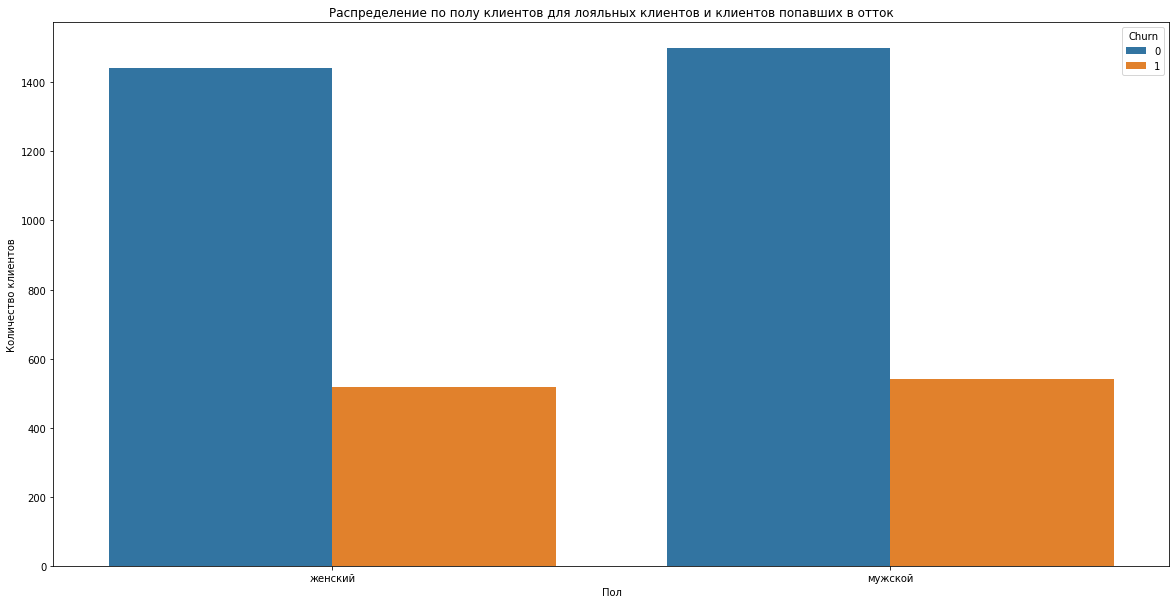

In [9]:
# Построим столбчатые гистограммы по признаку пола для клиентов оставшихся в фитнес-центре и попавших в отток
fig = plt.figure(figsize=(20,10))

sns.barplot(data=gym_churn.groupby(['gender', 'Churn']).agg({'Lifetime': 'count'}).reset_index(),
            x='gender',y='Lifetime',hue='Churn');

# Добавим подписи к графику
plt.title('Распределение по полу клиентов для лояльных клиентов и клиентов попавших в отток')
plt.xlabel('Пол')
plt.ylabel('Количество клиентов')
xlabels = ['женский', 'мужской']
plt.xticks(range(2),xlabels, rotation=0);

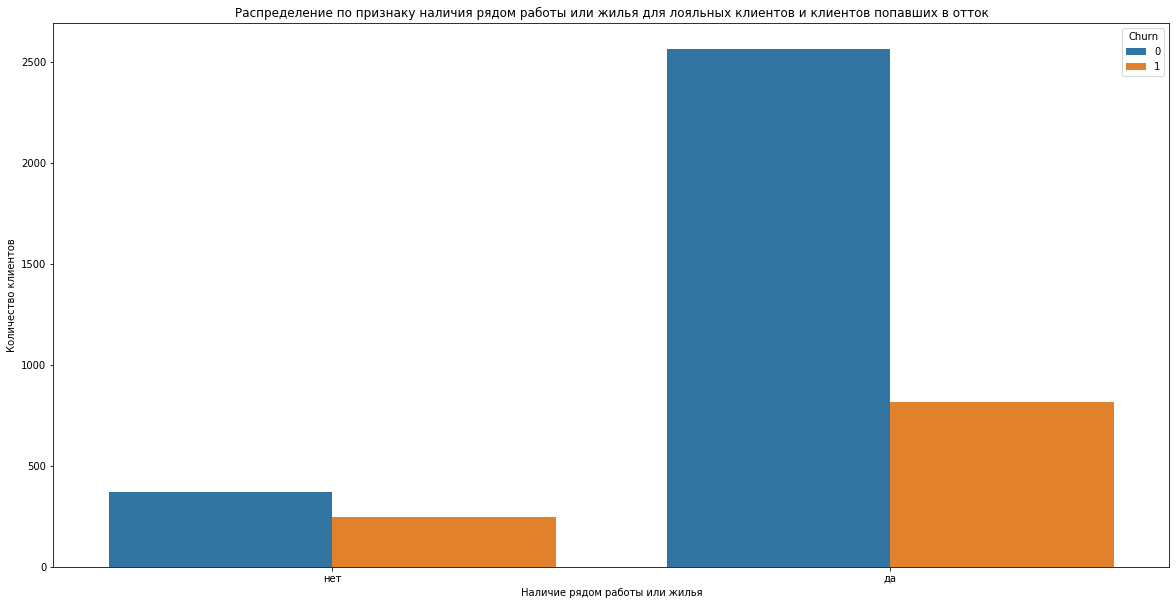

In [10]:
# Построим столбчатые гистограммы по признаку наличия рядом работы или жилья
# для клиентов оставшихся в фитнес-центре и попавших в отток
fig = plt.figure(figsize=(20,10))

sns.barplot(data=gym_churn.groupby(['Near_Location', 'Churn']).agg({'Lifetime': 'count'}).reset_index(),
            x='Near_Location',y='Lifetime',hue='Churn');

# Добавим подписи к графику
plt.title('Распределение по признаку наличия рядом работы или жилья для лояльных клиентов и клиентов попавших в отток')
plt.xlabel('Наличие рядом работы или жилья')
plt.ylabel('Количество клиентов')
xlabels = ['нет', 'да']
plt.xticks(range(2),xlabels, rotation=0);

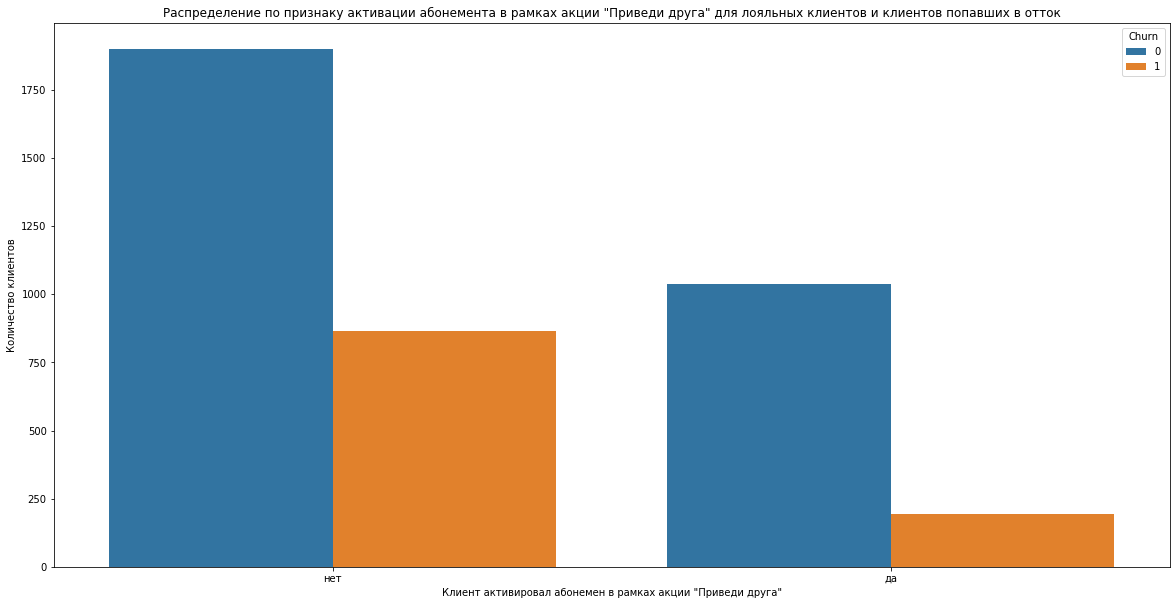

In [11]:
# Построим столбчатые гистограммы по признаку активации абонемента в рамках акции "Приведи друга"
# для клиентов оставшихся в фитнес-центре и попавших в отток
fig = plt.figure(figsize=(20,10))

sns.barplot(data=gym_churn.groupby(['Promo_friends', 'Churn']).agg({'Lifetime': 'count'}).reset_index(),
            x='Promo_friends',y='Lifetime',hue='Churn');

# Добавим подписи к графику
plt.title('Распределение по признаку активации абонемента в рамках акции "Приведи друга" для лояльных клиентов и клиентов попавших в отток')
plt.xlabel('Клиент активировал абонемен в рамках акции "Приведи друга"')
plt.ylabel('Количество клиентов')
xlabels = ['нет', 'да']
plt.xticks(range(2),xlabels, rotation=0);

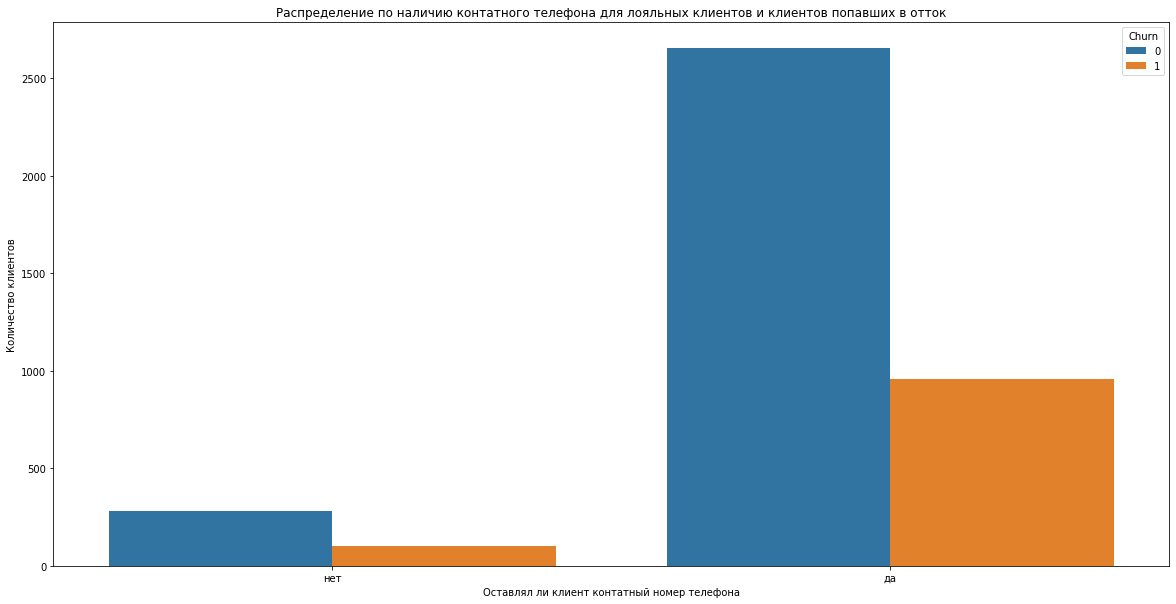

In [12]:
# Построим столбчатые гистограммы по наличию контатного телефона для клиентов оставшихся в фитнес-центре и попавших в отток
fig = plt.figure(figsize=(20,10))

sns.barplot(data=gym_churn.groupby(['Phone', 'Churn']).agg({'Lifetime': 'count'}).reset_index(),
            x='Phone',y='Lifetime',hue='Churn');

# Добавим подписи к графику
plt.title('Распределение по наличию контатного телефона для лояльных клиентов и клиентов попавших в отток')
plt.xlabel('Оставлял ли клиент контатный номер телефона')
plt.ylabel('Количество клиентов')
xlabels = ['нет', 'да']
plt.xticks(range(2),xlabels, rotation=0);

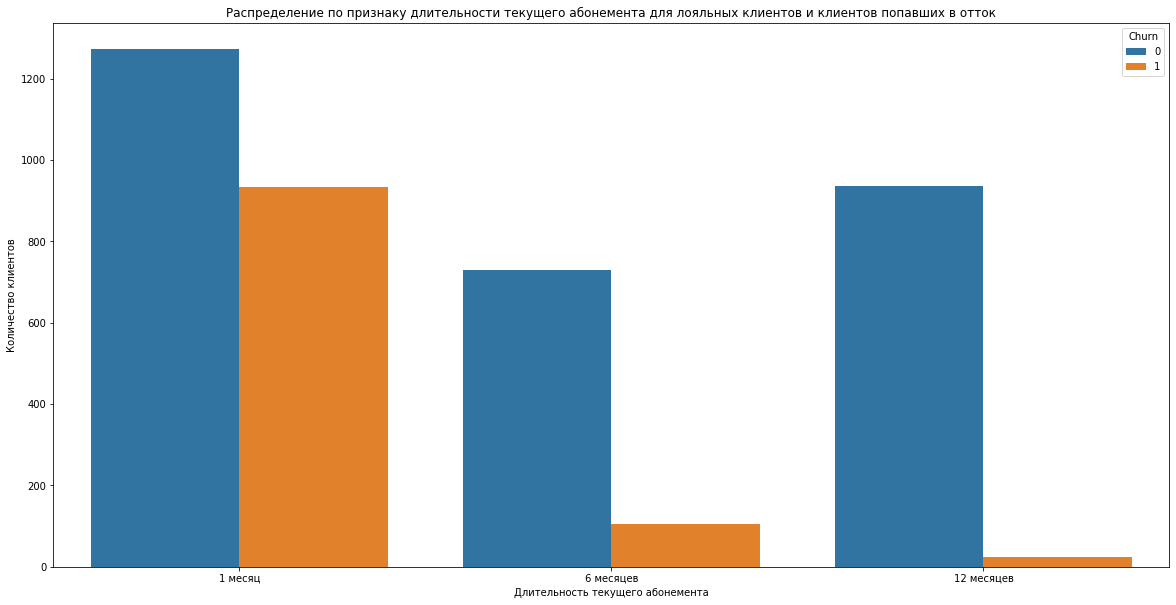

In [13]:
# Построим столбчатые гистограммы по признаку длительности текущего абонемента
# для клиентов оставшихся в фитнес-центре и попавших в отток
fig = plt.figure(figsize=(20,10))

sns.barplot(data=gym_churn.groupby(['Contract_period', 'Churn']).agg({'Lifetime': 'count'}).reset_index(),
            x='Contract_period',y='Lifetime',hue='Churn');

# Добавим подписи к графику
plt.title('Распределение по признаку длительности текущего абонемента для лояльных клиентов и клиентов попавших в отток')
plt.xlabel('Длительность текущего абонемента')
plt.ylabel('Количество клиентов')
xlabels = ['1 месяц', '6 месяцев', '12 месяцев']
plt.xticks(range(3),xlabels, rotation=0);

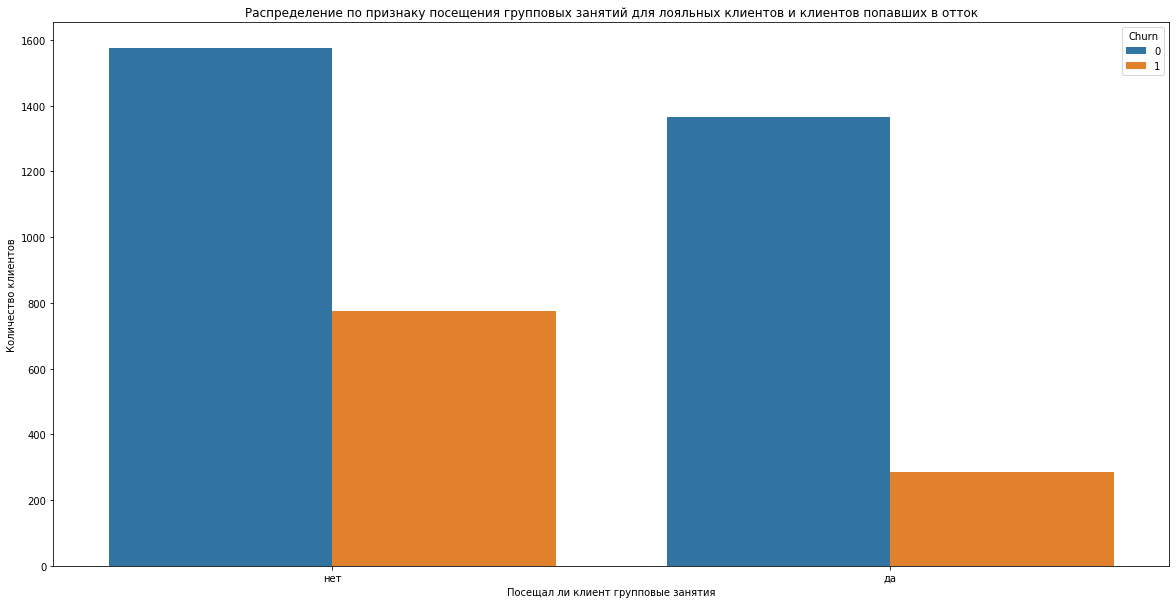

In [14]:
# Построим столбчатые гистограммы по признаку посещения групповых занятий
# для клиентов оставшихся в фитнес-центре и попавших в отток
fig = plt.figure(figsize=(20,10))

sns.barplot(data=gym_churn.groupby(['Group_visits', 'Churn']).agg({'Lifetime': 'count'}).reset_index(),
            x='Group_visits',y='Lifetime',hue='Churn');

# Добавим подписи к графику
plt.title('Распределение по признаку посещения групповых занятий для лояльных клиентов и клиентов попавших в отток')
plt.xlabel('Посещал ли клиент групповые занятия')
plt.ylabel('Количество клиентов')
xlabels = ['нет', 'да']
plt.xticks(range(2),xlabels, rotation=0);

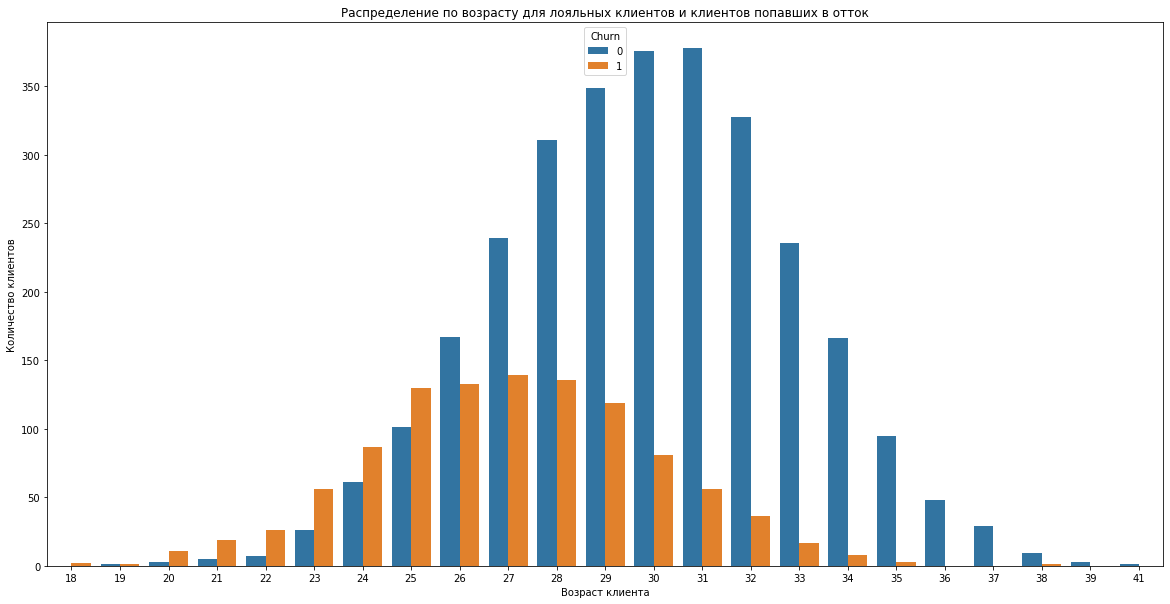

In [15]:
# Построим столбчатые гистограммы по возрасту
# для клиентов оставшихся в фитнес-центре и попавших в отток
fig = plt.figure(figsize=(20,10))

sns.barplot(data=gym_churn.groupby(['Age', 'Churn']).agg({'Lifetime': 'count'}).reset_index(),
            x='Age',y='Lifetime',hue='Churn');

# Добавим подписи к графику
plt.title('Распределение по возрасту для лояльных клиентов и клиентов попавших в отток')
plt.xlabel('Возраст клиента')
plt.ylabel('Количество клиентов');

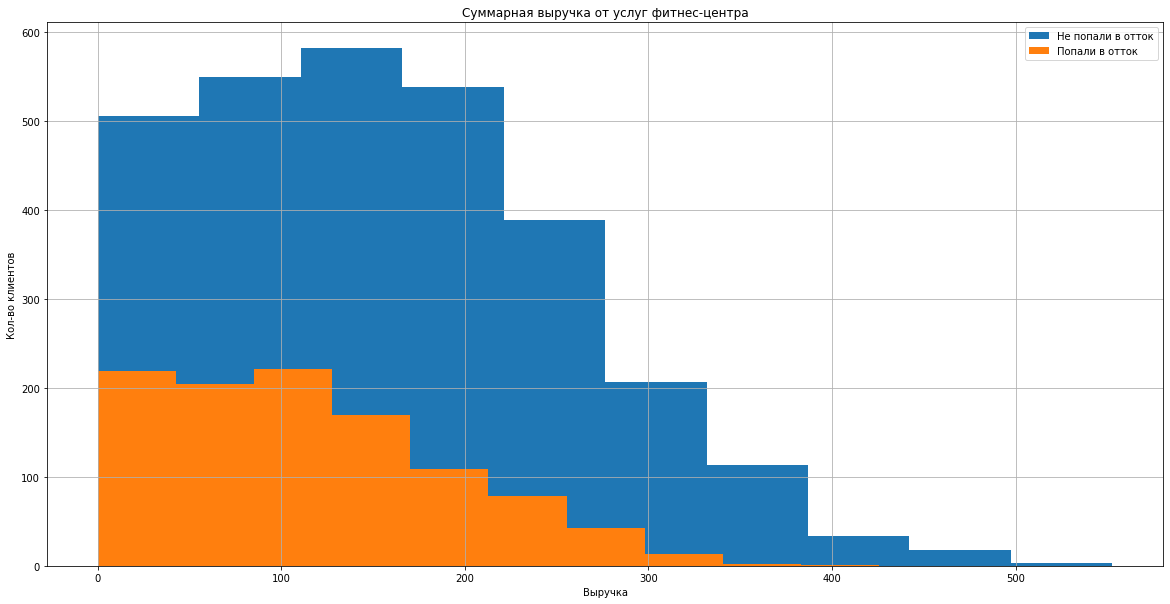

In [16]:
# Создадим таблицу с клиентами попавщих в отток
gym_churn_1 = gym_churn[gym_churn['Churn'] == 1]

# Создадим таблицу с клиентами не попавщих в отток
gym_churn_0 = gym_churn[gym_churn['Churn'] == 0]

# Зададим размер рисунка
fig = plt.figure(figsize=(20,10))

# Строим график по признаку Avg_additional_charges_total для клиентов не попавших в отток
gym_churn_0['Avg_additional_charges_total'].hist(label='Не попали в отток')

# Строим график выручки группы B
gym_churn_1['Avg_additional_charges_total'].hist(label='Попали в отток')

# Добавим подписи к графику
plt.legend()
plt.title('Суммарная выручка от услуг фитнес-центра')
plt.xlabel('Выручка')
plt.ylabel('Кол-во клиентов');

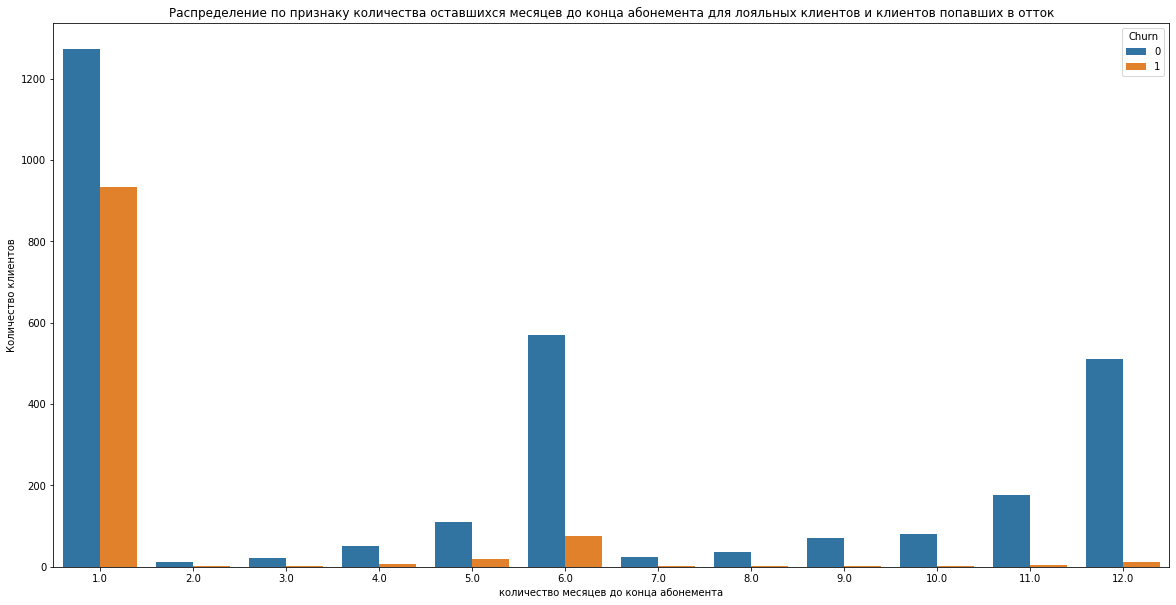

In [17]:
# Построим столбчатые гистограммы по признаку количества оставшихся месяцев до конца абонемента
# для клиентов оставшихся в фитнес-центре и попавших в отток
fig = plt.figure(figsize=(20,10))

sns.barplot(data=gym_churn.groupby(['Month_to_end_contract', 'Churn']).agg({'Lifetime': 'count'}).reset_index(),
            x='Month_to_end_contract',y='Lifetime',hue='Churn');

# Добавим подписи к графику
plt.title('Распределение по признаку количества оставшихся месяцев до конца абонемента для лояльных клиентов и клиентов попавших в отток')
plt.xlabel('количество месяцев до конца абонемента')
plt.ylabel('Количество клиентов');

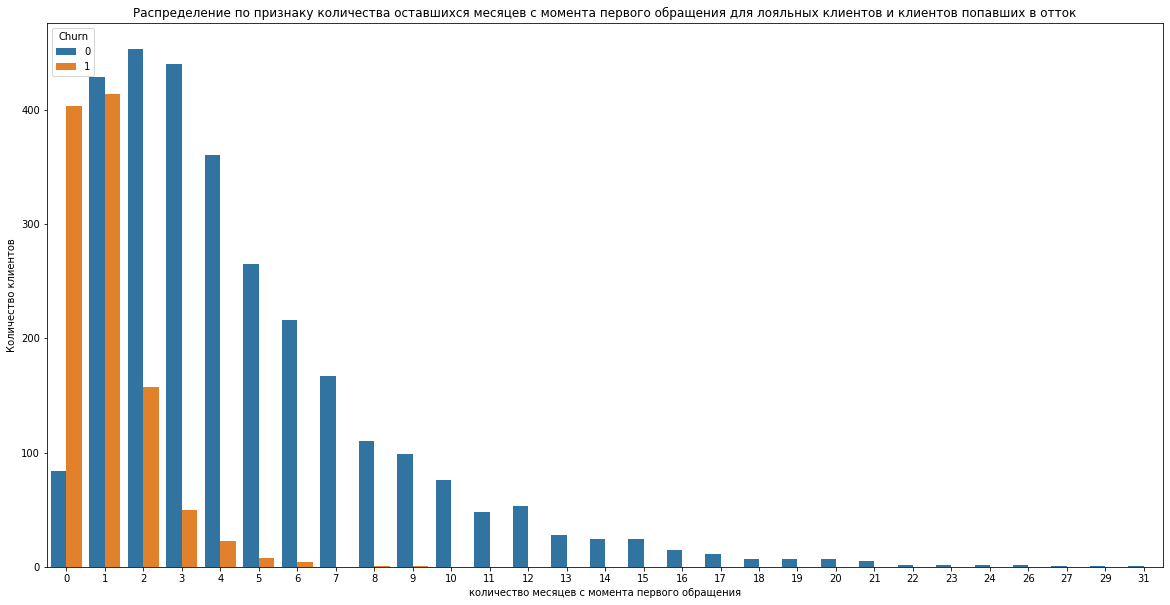

In [18]:
# Построим столбчатые гистограммы по признаку количества оставшихся месяцев с момента первого обращения
# для клиентов оставшихся в фитнес-центре и попавших в отток
fig = plt.figure(figsize=(20,10))

sns.barplot(data=gym_churn.groupby(['Lifetime', 'Churn']).agg({'Month_to_end_contract': 'count'}).reset_index(),
            x='Lifetime',y='Month_to_end_contract',hue='Churn');

# Добавим подписи к графику
plt.title('Распределение по признаку количества оставшихся месяцев с момента первого обращения для лояльных клиентов и клиентов попавших в отток')
plt.xlabel('количество месяцев с момента первого обращения')
plt.ylabel('Количество клиентов');

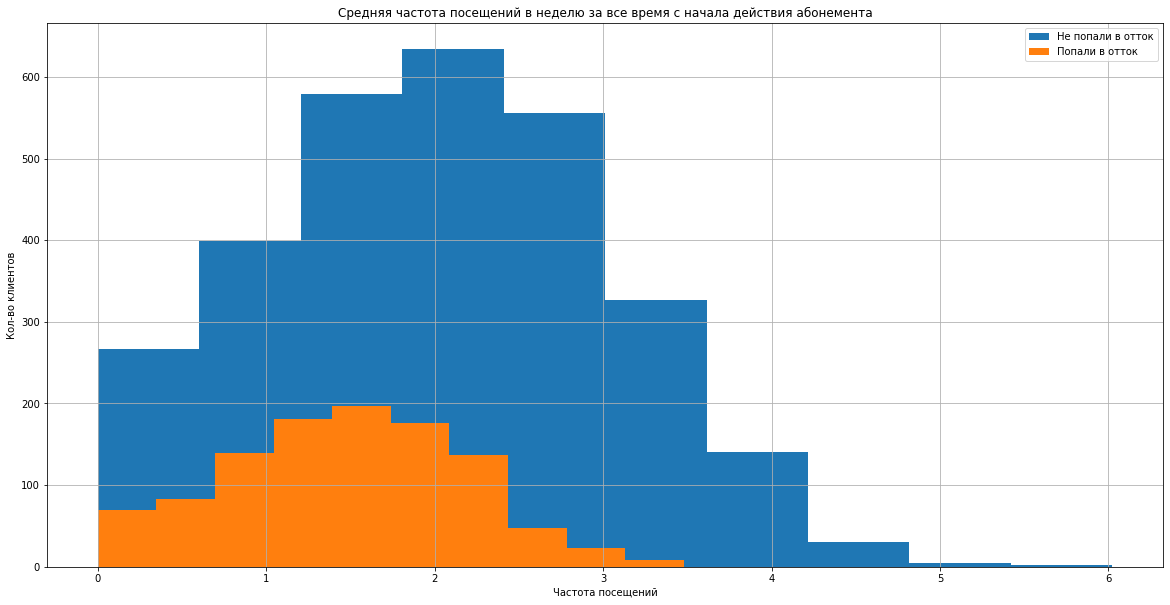

In [19]:
# Зададим размер рисунка
fig = plt.figure(figsize=(20,10))

# Строим график по признаку Avg_class_frequency_total для клиентов не попавших в отток
gym_churn_0['Avg_class_frequency_total'].hist(label='Не попали в отток')

# Строим график по признаку Avg_class_frequency_total для клиентов попавших в отток
gym_churn_1['Avg_class_frequency_total'].hist(label='Попали в отток')

# Добавим подписи к графику
plt.legend()
plt.title('Средняя частота посещений в неделю за все время с начала действия абонемента')
plt.xlabel('Частота посещений')
plt.ylabel('Кол-во клиентов');

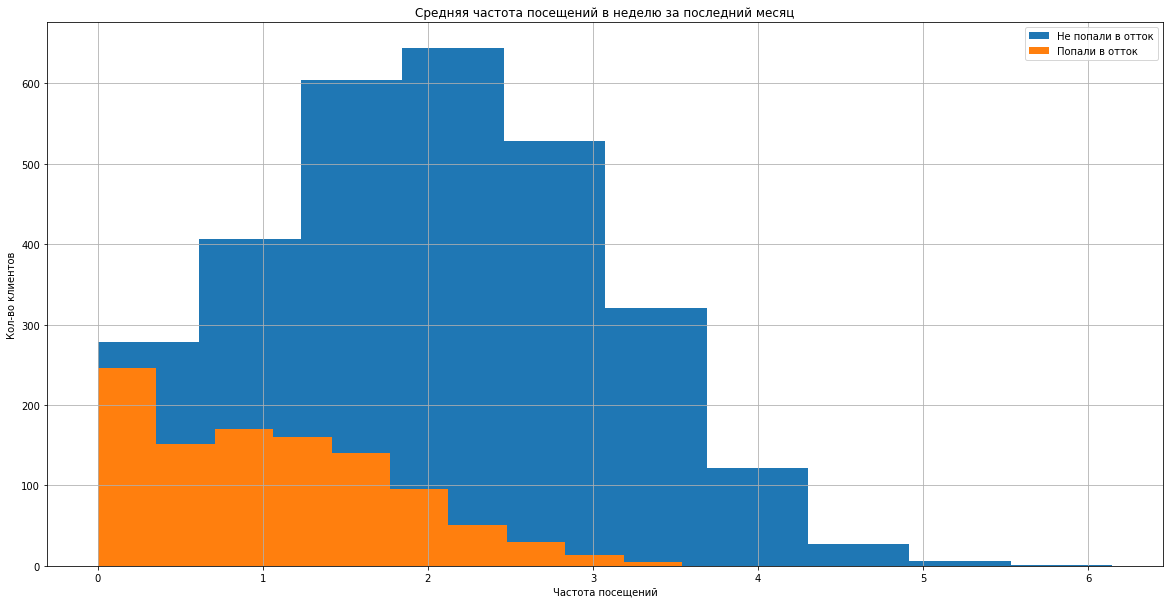

In [20]:
# Зададим размер рисунка
fig = plt.figure(figsize=(20,10))

# Строим график по признаку Avg_class_frequency_current_month для клиентов не попавших в отток
gym_churn_0['Avg_class_frequency_current_month'].hist(label='Не попали в отток')

# Строим график по признаку Avg_class_frequency_current_month для клиентов попавших в отток
gym_churn_1['Avg_class_frequency_current_month'].hist(label='Попали в отток')

# Добавим подписи к графику
plt.legend()
plt.title('Средняя частота посещений в неделю за последний месяц')
plt.xlabel('Частота посещений')
plt.ylabel('Кол-во клиентов');

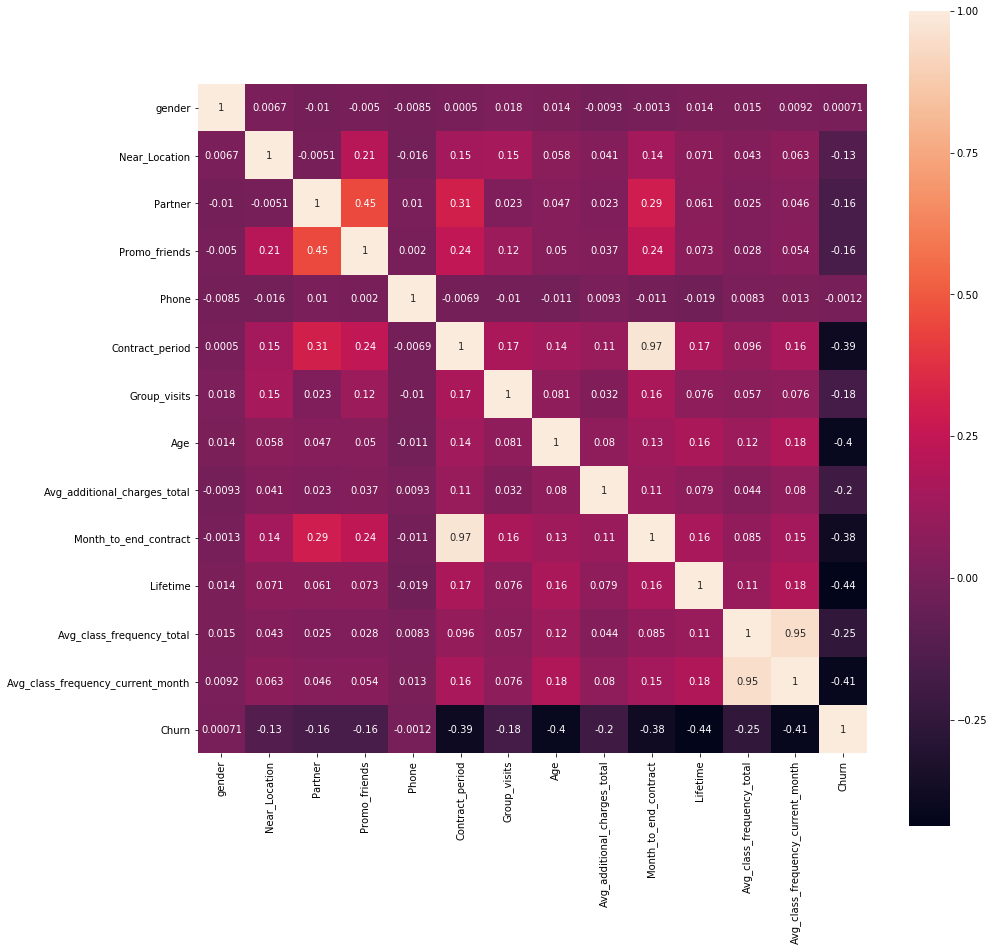

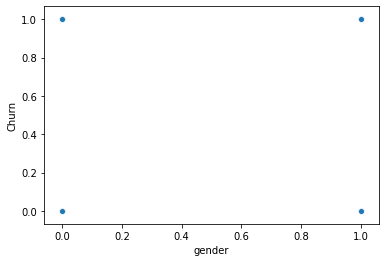

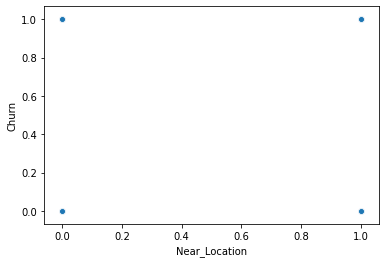

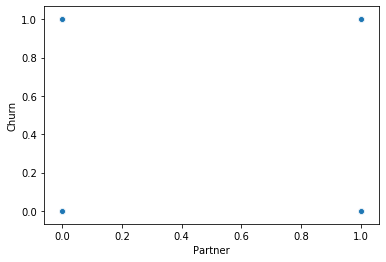

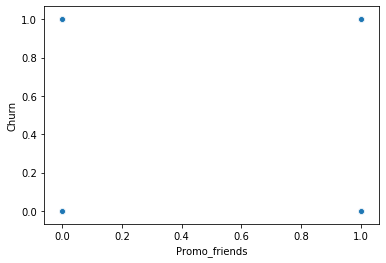

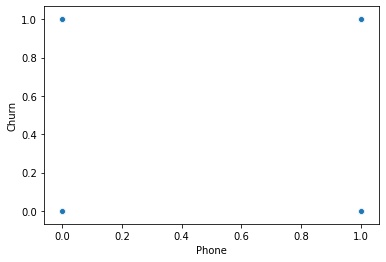

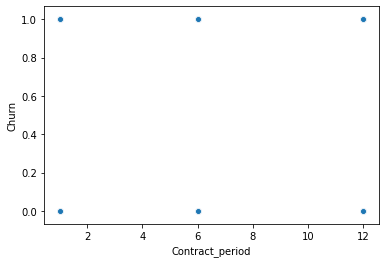

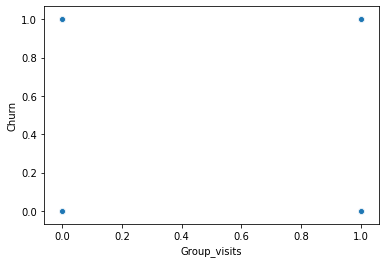

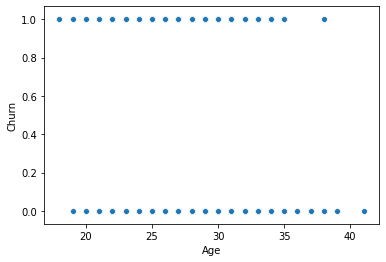

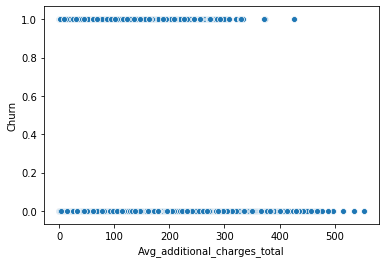

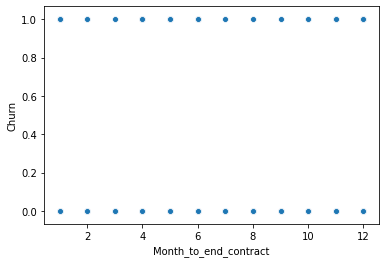

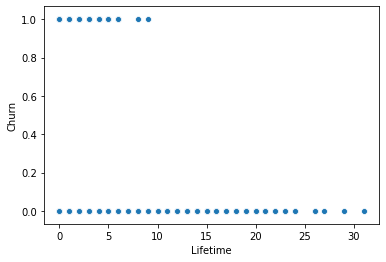

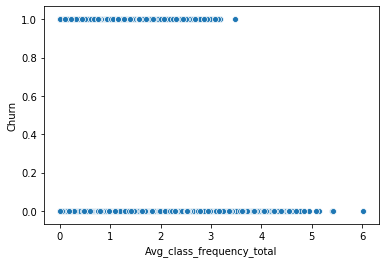

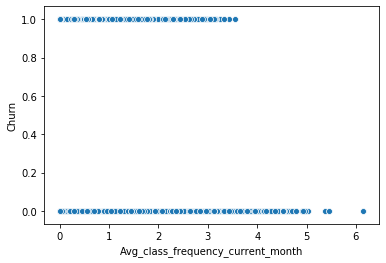

In [21]:
# создадим корреляционную матрицу
corr_gym_churn = gym_churn.corr()

# выведем цветовую карту для корреляционной матрице
plt.figure(figsize = (15,15))
sns.heatmap(corr_gym_churn, square = True, annot = True)
plt.show()

#построим попарные диаграммы рассеяния с целевой переменной для каждого признака
for col in gym_churn.drop('Churn', axis = 1).columns:
    sns.scatterplot(gym_churn[col], gym_churn['Churn'])
    plt.show()

Нет параметров сильно коррелирующих с параметром оттока (Churn), но есть несколько признаков которые сильно коррелируют  между собой, это пары признаков:
 - Avg_class_frequency_total и Avg_class_frequency_current_month, то есть частота посещений в неделю за всё время пользования абонементов и за последний месяц. 
 
Это говорит о том, что в основном клиенты, что за всё время, что в последний месяц в среднем посещают одинаковое количество раз фитнес-центр в неделю.
 - Contract_period и Month_to_end_contract, то есть срок действия абонемента и количество месяцев до окончания действия абонемента. 
 
Это говорит нам о том, что в нашей таблице в основном клиенты, которые только приобрели абонемент.

Для того, чтобы в обучении не доминировали пары сильно скоррелированных параметров, удалим параметры:
 - Avg_class_frequency_current_month - количество посещений в неделю за последний месяц
 - Month_to_end_contract - количество месяцев до окончания действия абонемента

In [22]:
# Удалим из таблицы параметр Avg_class_frequency_current_month
gym_churn = gym_churn.drop(['Avg_class_frequency_current_month'], axis=1)

# Удалим из таблицы параметр Month_to_end_contract
gym_churn = gym_churn.drop(['Month_to_end_contract'], axis=1)

## Шаг 3. Построение модели прогнозирования оттока клиентов

**Обучим модель на train-выборке двумя способами:**

 - Логистической регрессией,
 - Случайным лесом.
 
Также выведем метрики accuracy, precision и recall для обеих моделей на валидационной выборке

In [23]:
# определим функцию, которая будет выводить метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

# разделим данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop('Churn', axis = 1)
y = gym_churn['Churn']

# Разобьем данные на обучающую и валидационную выборку в соотношении 80 на 20
# Укажем параметр
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

#создадим объект класса StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающий и валидационный набор данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0, solver = 'liblinear')

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

# зададим алгоритм для новой модели на основе алгоритма случайного леса тз 100 деревьев
rf_model = RandomForestClassifier(n_estimators = 100,random_state = 0)

# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.91
	Precision: 0.83
	Recall: 0.83
Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.79


### Вывод

Модель логистической регрессии на основании показала себя лучше модели случайного леса:

Доля правильных ответов у модели логистической регрессии составила 0,91, так как точность случайного леса составила 0,89. Это говорит о том, что у модели логистической регрессии доля правильных ответов среди целевого класса на 2% выше, чем у случайного леса.

Точность у модели логистической регрессии составила 0,83, так как точность случайного леса составила 0,81. Это говорит о том, что у модели логистической регрессии доля правильных ответов среди целевого класса на 2% выше, чем у случайного леса.

Полнота у модели логистической регрессии составила 0,83, так как полнота случайного леса составила 0,79. Это говорит о том, что модель логистической регрессии нашла на 4% больше клиентов покинувших фитнес центр, чем модель случайного леса.

## Шаг 4. Кластеризация клиентов

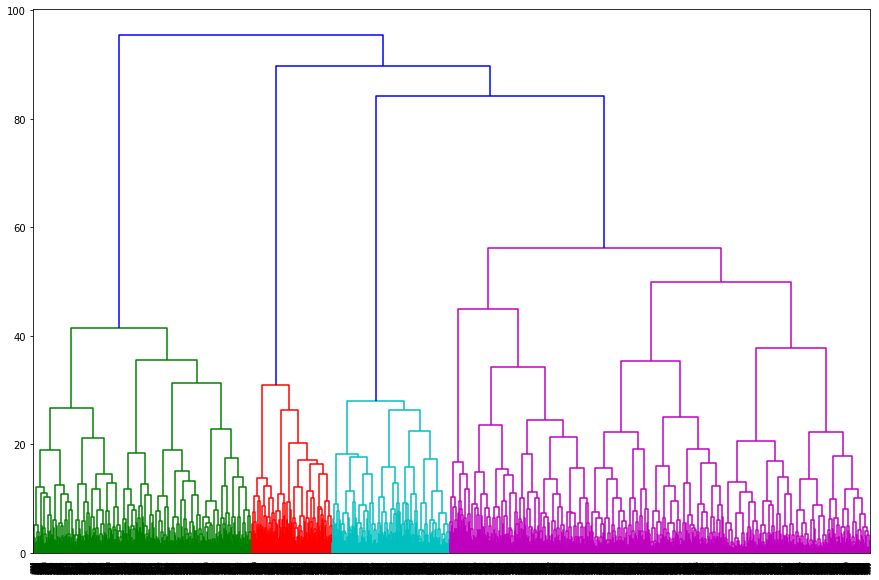

In [24]:
# Создадим новую таблицу и удалим в нем столбец Churn
gym_churn_3 = gym_churn.drop(['Churn'], axis=1)

# Стандартизируем таблицу
gym_churn_scaler = scaler.fit_transform(gym_churn_3)

# И передадим стандартизированную таблицу в качестве параметра функции
linked = linkage(gym_churn_scaler, method = 'ward') 

# Нарисуем дендограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Сделаем оптимальное число кластеров 5.

In [25]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state = 0)

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(gym_churn_scaler)

# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
gym_churn.groupby('cluster_km').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn
cluster_km,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


Уже даже по данным кластерам можно сделать выводы, что 1 кластер с самыми лояльными клиентами со средним показателем churn(оттока) в 12%. Данные клиенты выделаются Lifetime (время с момента первого обращения в фитнес-центр), оно равно 4,3 месяца, Promo_friends (факт посещения фитнес центра в рамках акции "приведи друга"), в среднем оно равно 89% для данной группы, и Partner (работодатель является партнером фитнес-центра), 89% работодателей клиентов данного кластера являются партнерами фитнес-центра. Длительность текущего абонемента в среднем составляет 7,6 месяцев (то есть большая часть на 6 месяцев и частично на 12 месяцев).

0 кластер является самой высокой группой по оттоку в среднем 40%, их среднее Lifetime составляет 3 месяца. Данный кластер отличается наименьшим показателем параметра Near_Location (наличие жилья или работы рядом с фитнес-центром) составляет 0%. Средняя длительность абонемента составляет 3 месяца.

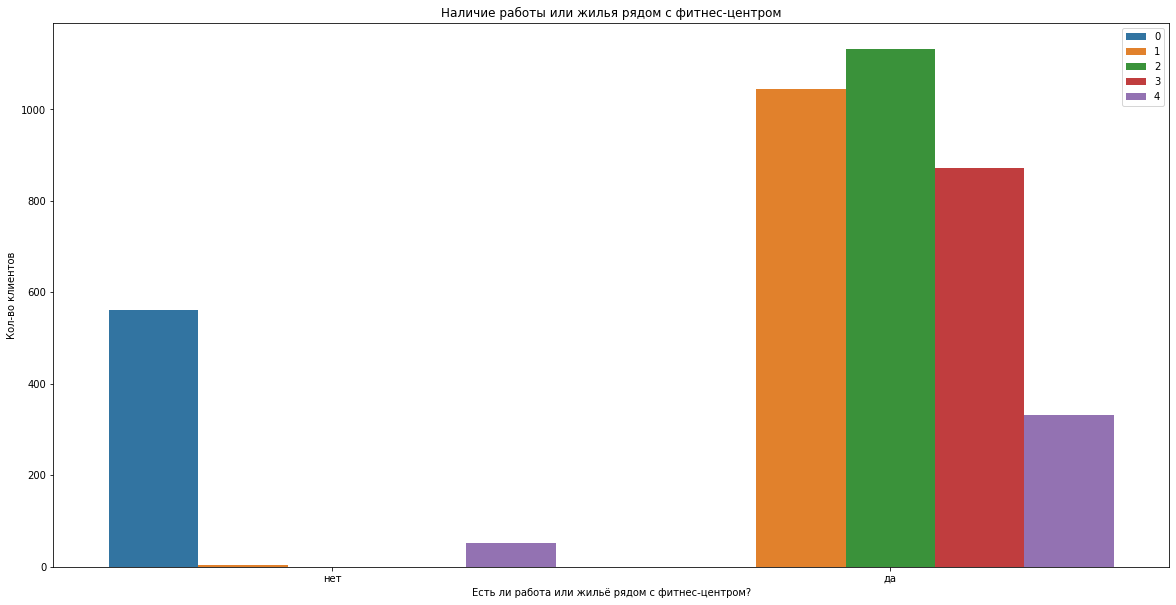

In [26]:
# Зададим размер рисунка
fig = plt.figure(figsize=(20,10))

# Строим график по признаку Near_Location для разных кластером
sns.countplot(data = gym_churn, x = 'Near_Location', hue = 'cluster_km')

# Добавим подписи к графику
plt.legend()
plt.title('Наличие работы или жилья рядом с фитнес-центром')
plt.xlabel('Есть ли работа или жильё рядом с фитнес-центром?')
plt.ylabel('Кол-во клиентов')
xlabels = ['нет', 'да']
plt.xticks(range(2),xlabels, rotation=0);

In [27]:
# Выведем таблицу по кластерам и признаку Near_Location в цифрах и процентах
gym_churn.groupby('cluster_km').agg({'Near_Location':['count', 'sum', lambda x: str(round(x.mean()*100,2)) +'%' ]})

Near_Location                 
                   count   sum <lambda_0>
cluster_km                               
0                    561     0       0.0%
1                   1050  1045     99.52%
2                   1132  1132     100.0%
3                    871   871     100.0%
4                    386   333     86.27%

По данному графику мы видим:

0% клиентов из кластера 0 имеют жилья или работы рядос с фитнес центром.

99% клиентов 1 кластера имеют жилье или работу рядом с фитнес центром.

100% клиентов кластероd 2 и 3 имеют работу или жильё рядом с фитнес центром.

86% клиентов кластера 4 имеют работу или жильё рабом с фитнес центром.

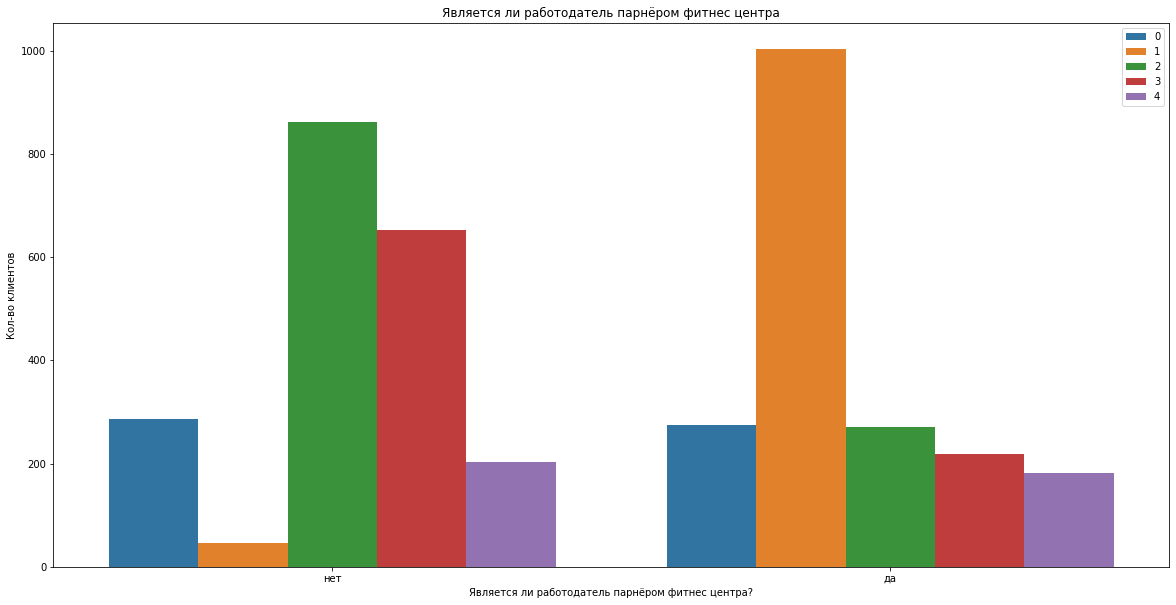

In [28]:
# Зададим размер рисунка
fig = plt.figure(figsize=(20,10))

# Строим график по признаку Partner для разных кластером
sns.countplot(data = gym_churn, x = 'Partner', hue = 'cluster_km')

# Добавим подписи к графику
plt.legend()
plt.title('Является ли работодатель парнёром фитнес центра')
plt.xlabel('Является ли работодатель парнёром фитнес центра?')
plt.ylabel('Кол-во клиентов')
xlabels = ['нет', 'да']
plt.xticks(range(2),xlabels, rotation=0);

In [29]:
# Выведем таблицу по кластерам и признаку Partner в цифрах и процентах
gym_churn.groupby('cluster_km').agg({'Partner':['count', 'sum', lambda x: str(round(x.mean()*100,2)) +'%' ]})

Partner                 
             count   sum <lambda_0>
cluster_km                         
0              561   274     48.84%
1             1050  1003     95.52%
2             1132   270     23.85%
3              871   218     25.03%
4              386   182     47.15%

По данному графику мы видим:

49% работодателей клиентов из кластера 0 являются партнёрами фитнец центра.

95% работодателей клиентов из кластера 1 являются партнёрами фитнец центра.

24% работодателей клиентов из кластера 2 являются партнёрами фитнец центра.

25% работодателей клиентов из кластера 3 являются партнёрами фитнец центра

47% работодателей клиентов из кластера 4 являются партнёрами фитнец центра.

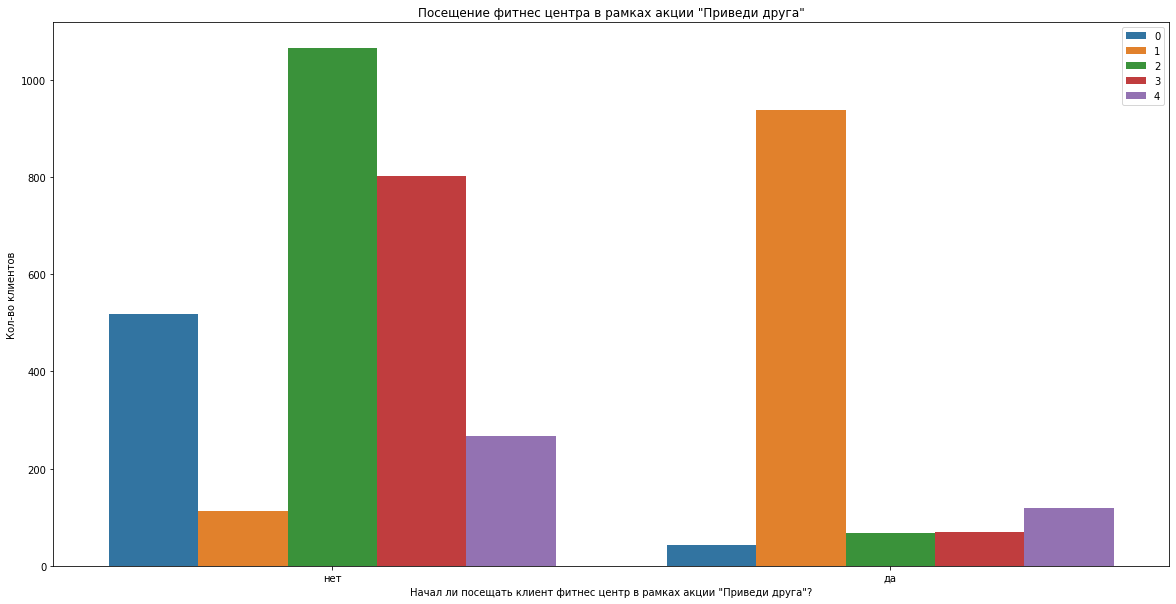

In [30]:
# Зададим размер рисунка
fig = plt.figure(figsize=(20,10))

# Строим график по признаку Promo_friends для разных кластером
sns.countplot(data = gym_churn, x = 'Promo_friends', hue = 'cluster_km')

# Добавим подписи к графику
plt.legend()
plt.title('Посещение фитнес центра в рамках акции "Приведи друга"')
plt.xlabel('Начал ли посещать клиент фитнес центр в рамках акции "Приведи друга"?')
plt.ylabel('Кол-во клиентов')
xlabels = ['нет', 'да']
plt.xticks(range(2),xlabels, rotation=0);

In [31]:
# Выведем таблицу по кластерам и признаку Promo_friends в цифрах и процентах
gym_churn.groupby('cluster_km').agg({'Promo_friends':['count', 'sum', lambda x: str(round(x.mean()*100,2)) +'%' ]})

Promo_friends                
                   count  sum <lambda_0>
cluster_km                              
0                    561   43      7.66%
1                   1050  937     89.24%
2                   1132   67      5.92%
3                    871   69      7.92%
4                    386  118     30.57%

По данному графику мы видим:

7% клиентов из кластера 0 Начали посещать фитнес центр в рамках акции "Приведи друга".

89% клиентов из кластера 1 Начали посещать фитнес центр в рамках акции "Приведи друга".

6% клиентов из кластера 2 Начали посещать фитнес центр в рамках акции "Приведи друга".

8% клиентов из кластера 3 Начали посещать фитнес центр в рамках акции "Приведи друга".

30% клиентов из кластера 4 Начали посещать фитнес центр в рамках акции "Приведи друга".

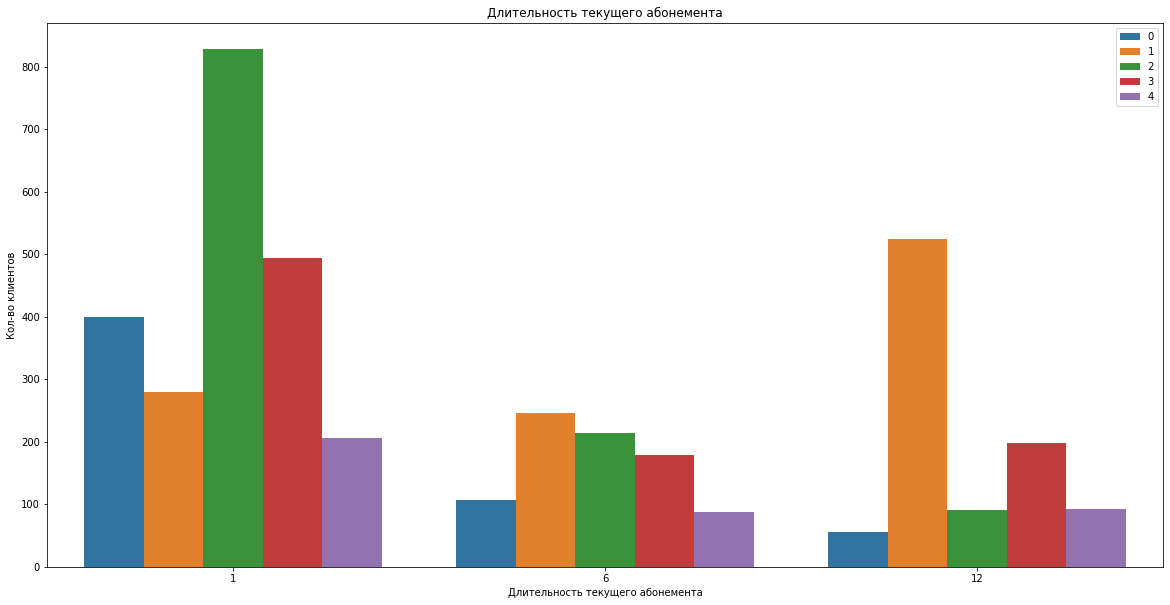

In [32]:
# Зададим размер рисунка
fig = plt.figure(figsize=(20,10))

# Строим график по признаку Contract_period для разных кластером
sns.countplot(data = gym_churn, x = 'Contract_period', hue = 'cluster_km')

# Добавим подписи к графику
plt.legend()
plt.title('Длительность текущего абонемента')
plt.xlabel('Длительность текущего абонемента')
plt.ylabel('Кол-во клиентов');

In [33]:
# Выведем таблицу по кластерам и признаку Contract_period в цифрах
gym_churn.groupby('cluster_km')['Contract_period'].value_counts()

cluster_km  Contract_period
0           1                  399
            6                  107
            12                  55
1           12                 524
            1                  280
            6                  246
2           1                  828
            6                  214
            12                  90
3           1                  494
            12                 198
            6                  179
4           1                  206
            12                  93
            6                   87
Name: Contract_period, dtype: int64

По данному графику мы видим:

Для клиентов из кластера 0 самый популярный абонемент на 1 месяц, 71% клиентов из данного кластера имеют абонемент на 1 месяц.

Для клиентов из кластера 1 самый популярный абонемент на 12 месяцев, 50% клиентов из данного кластера имеют абонемент на 12 месяцев.

Для клиентов из кластера 2 самый популярный абонемент на 1 месяц, 73% клиентов из данного кластера имеют абонемент на 1 месяц.

Для клиентов из кластера 3 самый популярный абонемент на 1 месяц, 56% клиентов из данного кластера имеют абонемент на 1 месяц.

Для клиентов из кластера 4 самый популярный абонемент на 1 месяц, 53% клиентов из данного кластера имеют абонемент на 1 месяц.

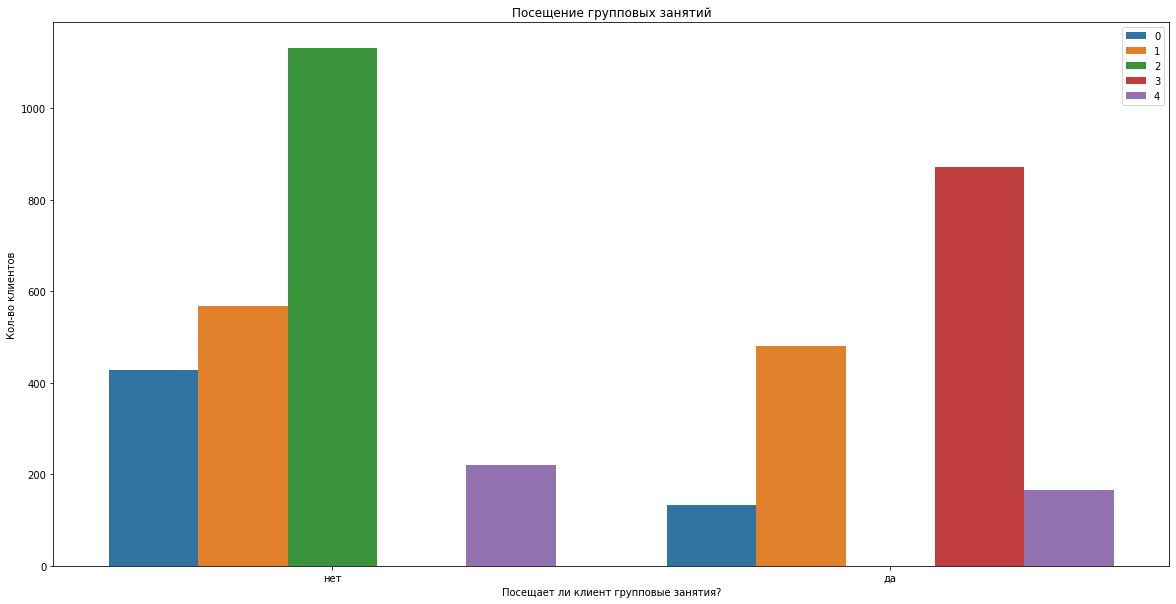

In [34]:
# Зададим размер рисунка
fig = plt.figure(figsize=(20,10))

# Строим график по признаку Group_visits для разных кластером
sns.countplot(data = gym_churn, x = 'Group_visits', hue = 'cluster_km')

# Добавим подписи к графику
plt.legend()
plt.title('Посещение групповых занятий')
plt.xlabel('Посещает ли клиент групповые занятия?')
plt.ylabel('Кол-во клиентов');
xlabels = ['нет', 'да']
plt.xticks(range(2),xlabels, rotation=0);

In [35]:
# Выведем таблицу по кластерам и признаку Group_visits в цифрах и процентах
gym_churn.groupby('cluster_km').agg({'Group_visits':['count', 'sum', lambda x: str(round(x.mean()*100,2)) +'%' ]})

Group_visits                
                  count  sum <lambda_0>
cluster_km                             
0                   561  132     23.53%
1                  1050  481     45.81%
2                  1132    0       0.0%
3                   871  871     100.0%
4                   386  165     42.75%

По данному графику мы видим:

23% клиентов из кластера 0 посещали групповые занятия.

46% клиентов из кластера 1 посещали групповые занятия.

0% клиентов из кластера 2 посещали групповые занятия.

100% клиентов из кластера 3 посещали групповые занятия.

43% клиентов из кластера 4 посещали групповые занятия.

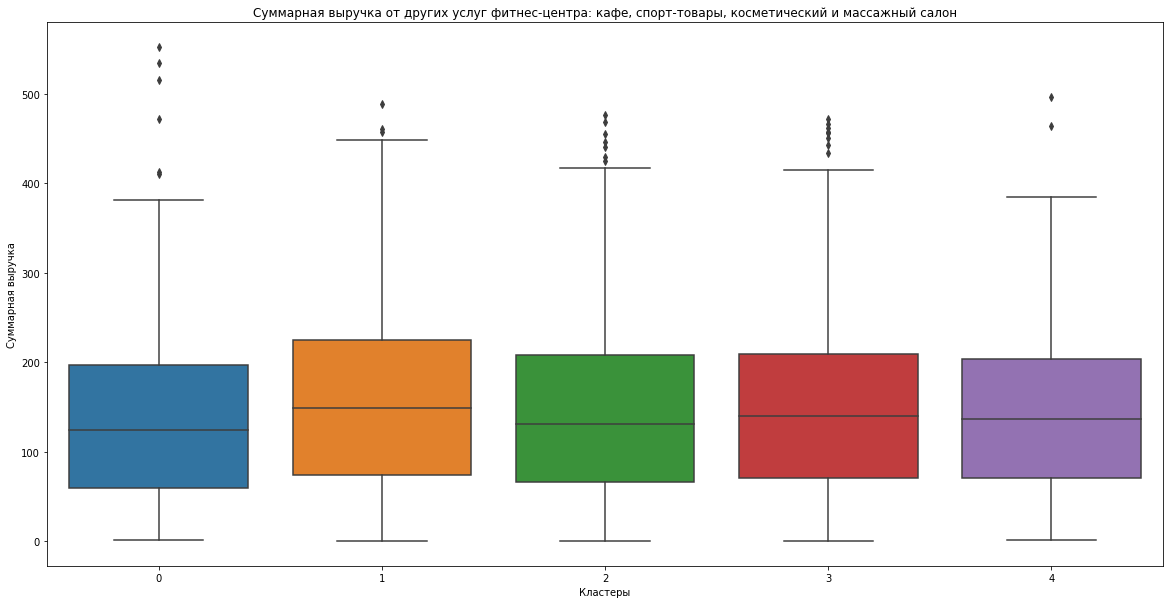

In [36]:
# Зададим размер рисунка
fig = plt.figure(figsize=(20,10))

# Строим график типа ящиков с усами по признаку Avg_additional_charges_total для разных кластером
sns.boxplot(x ='cluster_km',y = 'Avg_additional_charges_total', data = gym_churn)

# Добавим подписи к графику
plt.title('Суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон')
plt.xlabel('Кластеры')
plt.ylabel('Суммарная выручка');

По данному графику мы видим:

Суммарная выручка клиентов из кластера 0 составляет от 80 до 200 у.е. Среднее составляет 137,5 у.е.

Суммарная выручка клиентов из кластера 1 составляет от 85 до 215 у.е. Среднее составляет 155,8 у.е.

Суммарная выручка клиентов из кластера 2 составляет от 85 до 205 у.е. Среднее составляет 143,4 у.е.

Суммарная выручка клиентов из кластера 3 составляет от 85 до 205 у.е. Среднее составляет 148 у.е.

Суммарная выручка клиентов из кластера 4 составляет от 85 до 200 у.е. Среднее составляет 144,2 у.е.

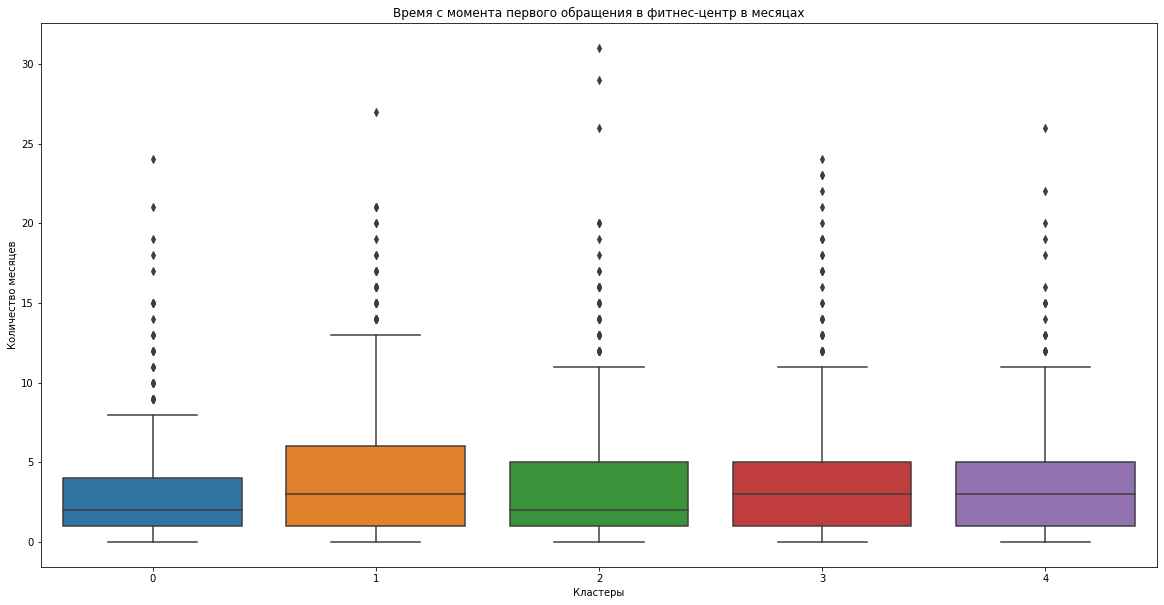

In [37]:
# Зададим размер рисунка
fig = plt.figure(figsize=(20,10))

# Строим график типа ящиков с усами по признаку Lifetime для разных кластером
sns.boxplot(x ='cluster_km',y = 'Lifetime', data = gym_churn)

# Добавим подписи к графику
plt.title('Время с момента первого обращения в фитнес-центр в месяцах')
plt.xlabel('Кластеры')
plt.ylabel('Количество месяцев');

По данному графику мы видим:

Клиенты из кластера 0 являются клиентами фитнес центра от 1 до 4 месяцев, среднее составляет 3 месяца.

Клиенты из кластера 1 являются клиентами фитнес центра от 1 до 6 месяцев, среднее составляет 4,3 месяца.

Клиенты из кластера 2 являются клиентами фитнес центра от 1 до 5 месяцев, среднее составляет 3,3 месяца.

Клиенты из кластера 3 являются клиентами фитнес центра от 1 до 5 месяцев, среднее составляет 3,76 месяца.

Клиенты из кластера 4 являются клиентами фитнес центра от 1 до 5 месяцев, среднее составляет 4 месяца.

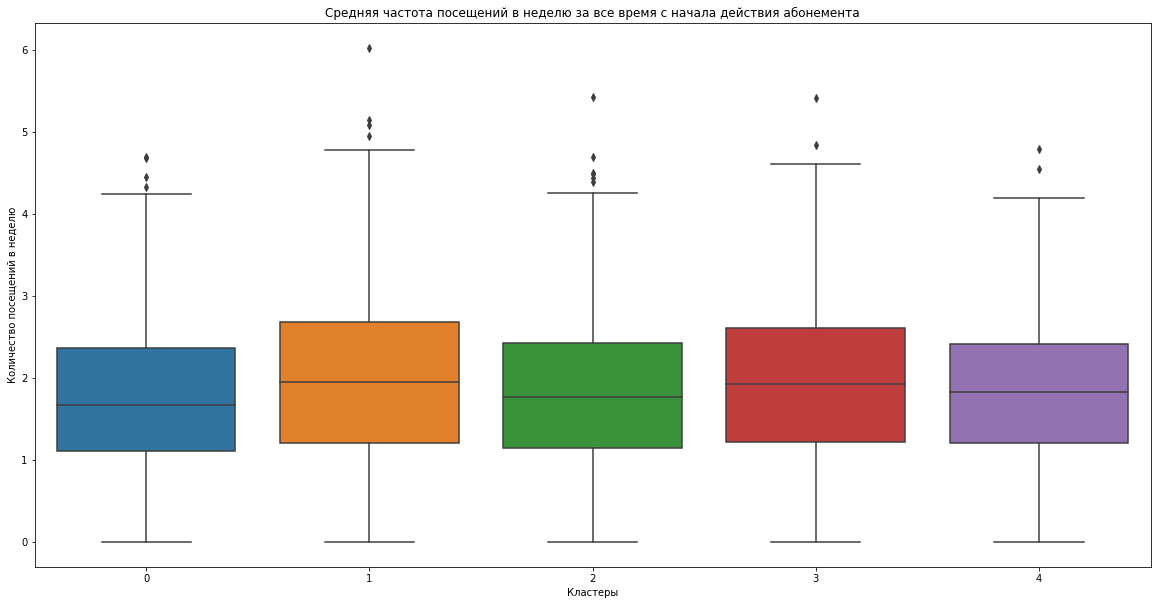

In [38]:
# Зададим размер рисунка
fig = plt.figure(figsize=(20,10))

# Строим график типа ящиков с усами по признаку Avg_class_frequency_total для разных кластером
sns.boxplot(x ='cluster_km',y = 'Avg_class_frequency_total', data = gym_churn)

# Добавим подписи к графику
plt.title('Средняя частота посещений в неделю за все время с начала действия абонемента')
plt.xlabel('Кластеры')
plt.ylabel('Количество посещений в неделю');

По данному графику мы видим:

Клиенты из кластера 0 посещают фитнес центр от 1 до 2,3 раз в неделю, среднее составляет 1,77 раз в неделю.

Клиенты из кластера 1 посещают фитнес центр от 1 до 2,7 раз в неделю, среднее составляет 1,97 раз в неделю.

Клиенты из кластера 2 посещают фитнес центр от 1 до 2,4 раз в неделю, среднее составляет 1,8 раз в неделю.

Клиенты из кластера 3 посещают фитнес центр от 1 до 2,6 раз в неделю, среднее составляет 1,94 раз в неделю.

Клиенты из кластера 4 посещают фитнес центр от 1 до 2,4 раз в неделю, среднее составляет 1,85 раз в неделю.

По признакам пола, наличия телефон и возраста решила не строить графики, т.к. эти параметры в среднем равны для каждого кластера.

In [39]:
# Выведем таблицу, с кластерами, где указано количество людей в кластере, 
# и скольких из них попало в отток в кол-ве людей и в %
gym_churn.groupby('cluster_km').agg({'Churn':['count', 'sum', lambda x: str(round(x.mean()*100,2)) +'%' ]})

Churn                
           count  sum <lambda_0>
cluster_km                      
0            561  224     39.93%
1           1050  127      12.1%
2           1132  432     38.16%
3            871  175     20.09%
4            386  103     26.68%

По данной таблице видим, что кластер 0 больше всего склонен к оттоку, в нем было 561 клиент из которых 224 попало в отток, это составляет 39,93%

Следующий кластер склонный к оттоку это 2 кластер, в нем было 1132 клиента и 432 клиентов попало в отток, что составило 38,16%

Кластер 1 наименее склонен к отоку, в нем было 1050 клиента и 127 клиентов попало в отток, что составило 12,1%

### Вывод

У нас всего 5 кластеров:

**Кластер 0** имеет 561 клиента, 224 из которых попали в **отток**, что составило **39,93%**. Для кластера характерно:

 - 0% клиентов имеют жилья или работы рядос с фитнес центром.
 - 49% работодателей клиентов являются партнёрами фитнец центра.
 - 7 % клиентов начали посещать фитнес центр в рамках акции "Приведи друга".
 - Самый популярный абонемент на 1 месяц, 71% клиентов из данного кластера имеют абонемент на 1 месяц.
 - 23% клиентов посещали групповые занятия.
 - Суммарная выручка составляет от 80 до 200 у.е. Среднее составляет 137,5 у.е.
 - Являются клиентами фитнес центра от 1 до 4 месяцев, среднее составляет 3 месяца.
 - Посещают фитнес центр от 1 до 2,3 раз в неделю, среднее составляет 1,77 раз в неделю.

**Кластер 1** имеет 1050 клиента, 127 из которых попали в **отток**, что составило **12,1**%. Для кластера характерно:
 - 99% клиентов имеют жилья или работы рядос с фитнес центром.
 - 95% работодателей клиентов являются партнёрами фитнец центра.
 - 89 % клиентов начали посещать фитнес центр в рамках акции "Приведи друга".
 - Самый популярный абонемент на 12 месяцев, 50% клиентов из данного кластера имеют абонемент на 12 месяцев.
 - 46% клиентов посещали групповые занятия.
 - Суммарная выручка составляет от 85 до 215 у.е. Среднее составляет 155,8 у.е.
 - Являются клиентами фитнес центра от 1 до 6 месяцев, среднее составляет 4,3 месяца.
 - Посещают фитнес центр от 1 до 2,7 раз в неделю, среднее составляет 1,97 раз в неделю.
 
**Кластер 2** имеет 1132 клиента, 432 из которых попали в **отток**, что составило **38,16%**. Для кластера характерно:
 - 100% клиентов имеют жилья или работы рядос с фитнес центром.
 - 24% работодателей клиентов являются партнёрами фитнец центра.
 - 6 % клиентов начали посещать фитнес центр в рамках акции "Приведи друга".
 - Самый популярный абонемент на 1 месяц, 73% клиентов из данного кластера имеют абонемент на 1 месяц.
 - 0% клиентов посещали групповые занятия.
 - Суммарная выручка составляет от 85 до 205 у.е. Среднее составляет 143,4 у.е.
 - Являются клиентами фитнес центра от 1 до 5 месяцев, среднее составляет 3,3 месяца.
 - Посещают фитнес центр от 1 до 2,4 раз в неделю, среднее составляет 1,8 раз в неделю.
 
**Кластер 3** имеет 871 клиента, 175 из которых попали в **отток**, что составило **20,09%**. Для кластера характерно:
 - 100% клиентов имеют жилья или работы рядос с фитнес центром.
 - 25% работодателей клиентов являются партнёрами фитнец центра.
 - 8 % клиентов начали посещать фитнес центр в рамках акции "Приведи друга".
 - Самый популярный абонемент на 1 месяц, 56% клиентов из данного кластера имеют абонемент на 1 месяц.
 - 100% клиентов посещали групповые занятия.
 - Суммарная выручка составляет от 85 до 205 у.е. Среднее составляет 148 у.е.
 - Являются клиентами фитнес центра от 1 до 5 месяцев, среднее составляет 3,76 месяца.
 - Посещают фитнес центр от 1 до 2,6 раз в неделю, среднее составляет 1,94 раз в неделю.

**Кластер 4** имеет 386 клиента, 103 из которых попали в **отток**, что составило **26,68%**. Для кластера характерно:
 - 86% клиентов имеют жилья или работы рядос с фитнес центром.
 - 47% работодателей клиентов являются партнёрами фитнец центра.
 - 30 % клиентов начали посещать фитнес центр в рамках акции "Приведи друга".
 - Самый популярный абонемент на 1 месяц, 53% клиентов из данного кластера имеют абонемент на 1 месяц.
 - 43% клиентов посещали групповые занятия.
 - Суммарная выручка составляет от 85 до 200 у.е. Среднее составляет 144,2 у.е.
 - Являются клиентами фитнес центра от 1 до 5 месяцев, среднее составляет 4 месяца.
 - Посещают фитнес центр от 1 до 2,4 раз в неделю, среднее составляет 1,85 раз в неделю.

## Выводы и базовые рекомендации по работе с клиентами

У нас хорошие данные на 4000 клиентов без одного пропуска.

Если не смотреть на кластеризацию клиентов, и смотреть по параметрам, то можно заметить:
 - Среди тех клиентов, у кого нет работы или жилья рядом с фитнесом выше отток, чем у тех клиентов у которых есть что-то из этих двух вариентов.
 - Среди клиентов, которые пришли в рамках программы "приведи друга", шанс оттока ниже, чем у тех, кто пришёл сам по себе.
 - Самый высокий процент оттока у клиентов имеющих абонемент в 1 месяц.
 - Среди клиентов, которые посещают групповые занятия, шанс оттока ниже, чем у тех, кто их не посещает.
 - у клиентов в возрасте от 18 до 25, больше людей, кто покинул фитнес-центр, чем остался в нём, в возрасте 26 и 27, около 50% кто покидает фитнес.
 - Клиенты у которых остается до конца абонемента 1 месяц, чаще других покидают данный фитнес-центр
 - Чаще всего фитнес покидают клиенты, у которых с момента первого посещения прошло 1 или 2 месяца
 
Самые сильно взаимозависимые между собой параметры, это параметры:
 - Avg_class_frequency_total и Avg_class_frequency_current_month, то есть частота посещений в неделю за всё время пользования абонементов и за последний месяц.

Это говорит о том, что в основном клиенты, что за всё время, что в последний месяц в среднем посещают одинаковое количество раз фитнес-центр в неделю.

- Contract_period и Month_to_end_contract, то есть срок действия абонемента и количество месяцев до окончания действия абонемента.

Чтобы пара сильно скоррелированных параметров не повлияла на обучение, я удалила:
 - Avg_class_frequency_current_month - количество посещений в неделю за последний месяц
 - Month_to_end_contract - количество месяцев до окончания действия абонемента


Мы сделали прогнозирование двумя способами: Логистической регрессией и Случайным лесом.

Среди них более результативным оказалась логистическая регрессия, у неё доля правильных ответов на 2% выше, точность на 2% выше и полнота на 4% выше, чем у случайного леса.

Также мы провели кластеризацию клиентов и выявили 5 кластеров:

**Кластер 0** имеет 561 клиента, 224 из которых попали в **отток**, что составило **39,93%**. Для кластера характерно:

 - 0% клиентов имеют жилья или работы рядос с фитнес центром.
 - 49% работодателей клиентов являются партнёрами фитнес центра.
 - 7 % клиентов начали посещать фитнес центр в рамках акции "Приведи друга".
 - Самый популярный абонемент на 1 месяц, 71% клиентов из данного кластера имеют абонемент на 1 месяц.
 - 23% клиентов посещали групповые занятия.
 - Суммарная выручка составляет от 80 до 200 у.е. Среднее составляет 137,5 у.е.
 - Являются клиентами фитнес центра от 1 до 4 месяцев, среднее составляет 3 месяца.
 - Посещают фитнес центр от 1 до 2,3 раз в неделю, среднее составляет 1,77 раз в неделю.

**Кластер 1** имеет 1050 клиента, 127 из которых попали в **отток**, что составило **12,1**%. Для кластера характерно:
 - 99% клиентов имеют жилья или работы рядос с фитнес центром.
 - 95% работодателей клиентов являются партнёрами фитнес центра.
 - 89 % клиентов начали посещать фитнес центр в рамках акции "Приведи друга".
 - Самый популярный абонемент на 12 месяцев, 50% клиентов из данного кластера имеют абонемент на 12 месяцев.
 - 46% клиентов посещали групповые занятия.
 - Суммарная выручка составляет от 85 до 215 у.е. Среднее составляет 155,8 у.е.
 - Являются клиентами фитнес центра от 1 до 6 месяцев, среднее составляет 4,3 месяца.
 - Посещают фитнес центр от 1 до 2,7 раз в неделю, среднее составляет 1,97 раз в неделю.
 
**Кластер 2** имеет 1132 клиента, 432 из которых попали в **отток**, что составило **38,16%**. Для кластера характерно:
 - 100% клиентов имеют жилья или работы рядос с фитнес центром.
 - 24% работодателей клиентов являются партнёрами фитнес центра.
 - 6 % клиентов начали посещать фитнес центр в рамках акции "Приведи друга".
 - Самый популярный абонемент на 1 месяц, 73% клиентов из данного кластера имеют абонемент на 1 месяц.
 - 0% клиентов посещали групповые занятия.
 - Суммарная выручка составляет от 85 до 205 у.е. Среднее составляет 143,4 у.е.
 - Являются клиентами фитнес центра от 1 до 5 месяцев, среднее составляет 3,3 месяца.
 - Посещают фитнес центр от 1 до 2,4 раз в неделю, среднее составляет 1,8 раз в неделю.
 
**Кластер 3** имеет 871 клиента, 175 из которых попали в **отток**, что составило **20,09%**. Для кластера характерно:
 - 100% клиентов имеют жилья или работы рядос с фитнес центром.
 - 25% работодателей клиентов являются партнёрами фитнес центра.
 - 8 % клиентов начали посещать фитнес центр в рамках акции "Приведи друга".
 - Самый популярный абонемент на 1 месяц, 56% клиентов из данного кластера имеют абонемент на 1 месяц.
 - 100% клиентов посещали групповые занятия.
 - Суммарная выручка составляет от 85 до 205 у.е. Среднее составляет 148 у.е.
 - Являются клиентами фитнес центра от 1 до 5 месяцев, среднее составляет 3,76 месяца.
 - Посещают фитнес центр от 1 до 2,6 раз в неделю, среднее составляет 1,94 раз в неделю.

**Кластер 4** имеет 386 клиента, 103 из которых попали в **отток**, что составило **26,68%**. Для кластера характерно:
 - 86% клиентов имеют жилья или работы рядос с фитнес центром.
 - 47% работодателей клиентов являются партнёрами фитнес центра.
 - 30 % клиентов начали посещать фитнес центр в рамках акции "Приведи друга".
 - Самый популярный абонемент на 1 месяц, 53% клиентов из данного кластера имеют абонемент на 1 месяц.
 - 43% клиентов посещали групповые занятия.
 - Суммарная выручка составляет от 85 до 200 у.е. Среднее составляет 144,2 у.е.
 - Являются клиентами фитнес центра от 1 до 5 месяцев, среднее составляет 4 месяца.
 - Посещают фитнес центр от 1 до 2,4 раз в неделю, среднее составляет 1,85 раз в неделю.
 
 
Могу предложить следующие рекомендации:
 - Так как основной отток клиентов происходит, у которых с момента первого посещения прошел 1 или 2 месяц, и у кластера 2 с самым низким процентов оттока самая высокая ручка по услогам фитнес центра. Возможно клиенты не знают всех доступных услуг Вашего фитнес-центра. Нужно чтобы менеджеры по продажам или тренеры больше общались с клиентами и побуждали их задавать вопросы по непонятным аспектам Вашего центра и пользоваться доп. услугами. Возможно в Вашем фитнес центре работают лучшие массажисты или тренера.
 - Основной отток клиентов происходит у тех клиентов, кто приобрёл абонемент на 1 месяц. Нужно запустить акцию со скидками для абонементов для 6 или 12 месяцев. (у кластера 2 с самым низким оттоком самый популярный абонемент на 12 месяцев)
 - Основной отток клиентов происходит у клиентов более молодого возвраста (от 18 до 27 лет). И также у двух кластеров (0 и 2) самый низкий показатель посещения груповых занятий(23% и 0% соответственно). Так что более молодых клиентов стоит побуждать к посещению групповых занятий.
 - Основной отток клиентов происходит в последние 2 месяца, оставшихся от абонемента. По этому в последние 3 месяца (чтобы клиент даже не успел задуматься, о том, чтобы покинуть фитнес) нужно мотивировать клиентов к продлению абонемента. Возможно нужно запустить какую-нибудь акцию.
 - У второго по величине оттока кластера всего 24% работодателей являются клиентами фитнес центра. Потому я рекомендую заключать договора с большим количеством работодателей.
 - Клиенты кластеров с высокими показателями оттока реже остальных начали посещать фитнес по акции приведи друга, т.к. клиенты кластера с самым низким показателем оттока в 89% случаев начали посещать фитнес по рекомендации друга. Возможно не так сильно влияет именно начало посещения фитнеса, сколько сам факт посещения данного фитнеса с кем-то из знакомых. Стоит запустить какую-нибудь акцию с данной тематикой, например, что друзья которых клиент зовёт посещать данный фитнес получают скидку на первый абонемент (желательно на большее количество месяцев), а сам "друг", который порекомендовал фитнес, получает скидку на какие-то доп.услуги фитнеса.
 - У кластера с самым высоким показателем оттока 0% клиентов имеют рядом с работой или фитнесом работу. Потому возможно нужно провести анкетирование клиентов, и если вы планируете расширяться, открывать новый фитнес рядом с таким клиентами, чтобы получить их лояльность. Или же в спальных районах, где много клиентов будут жить рядом с вашим новым филиалом фитнес центра.